# Proyectos bitbucket

## 📦Obtener los datos

#### Repositorios

Consultar los repositorios

In [213]:
%pip install python-dotenv

import requests
import pandas as pd
from dotenv import load_dotenv
import os
from IPython.display import display


# Configura tus credenciales
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

username = os.getenv("BITBUCKET_USERNAME")
app_password = os.getenv("BITBUCKET_APP_PASSWORD")
workspace = os.getenv("BITBUCKET_WORKSPACE")


url_repos = f"https://api.bitbucket.org/2.0/repositories/{workspace}"

response = requests.get(url_repos, auth=(username, app_password))

if response.status_code == 200:
    repositorios = response.json()
    print(f"Repositorios en {workspace}:")
    repos_data = []
    for repo in repositorios.get("values", []):
        repos_data.append(
            {
                "Nombre": repo.get("name"),
                "URL": repo.get("links", {}).get("html", {}).get("href"),
            }
        )
    repos_df = pd.DataFrame(repos_data)
    repos_df = repos_df.sort_values(
        by="Nombre"
    )  # Ordenar por nombre del repositorio en ascendente
    # print(repos_df)
else:
    print("Error al obtener repositorios:", response.status_code, response.text)

# Almacenar los repositorios en una variable para uso posterior
repositorios = [
    repo["Nombre"]
    for repo in repos_data
    if repo["Nombre"] not in ["pgp", "Pruebas_erp", "Inventario", "b2c", "efi"]
]


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Repositorios en itmz:


Listado de repositorios

In [214]:
repos_df = pd.DataFrame(repositorios, columns=["Repositorio"])
display(repos_df)

,Repositorio
0,api_it_management
1,b2b
2,ApiEmpleados
3,fip
4,api_data_ERP


#### Funciones

In [215]:
# Función para obtener todos los elementos paginados
def get_all_items(url, params=None):
    items = []
    response = requests.get(url, params=params, auth=(username, app_password))
    if response.status_code != 200:
        print("Error:", response.status_code, response.text)
        return items
    data = response.json()
    items.extend(data.get("values", []))
    return items


#### Pull requests y commits

Consultar todos los estados de PR's.

Filtrar 50 registros por páginas, 3 páginas

In [216]:
cantidad_paginas = 4
registros_por_pagina = 50  # Creo que no soporta más de 50 registros por página

# Obtener pull requests
pull_requests = []

for repo_slug in repositorios:
    # for repo_slug in ["fip", "b2b"]:
    pr_url = f"https://api.bitbucket.org/2.0/repositories/{workspace}/{repo_slug}/pullrequests"
    for page in range(1, cantidad_paginas + 1):
        pull_requests.extend(
            get_all_items(
                pr_url,
                params={"page": page, "pagelen": registros_por_pagina, "state": "ALL"},
            )
        )
        print(f"Obteniendo pull requests, repositorio: '{repo_slug}' - página: {page}")

print(f"✅Total de pull requests: {len(pull_requests)}\n")


# Obtener commits
commits = []

for repo_slug in repositorios:
    # for repo_slug in ["fip", "b2b"]:
    commits_url = (
        f"https://api.bitbucket.org/2.0/repositories/{workspace}/{repo_slug}/commits"
    )
    for page in range(1, cantidad_paginas + 1):
        commits.extend(
            get_all_items(
                commits_url,
                params={"page": page, "pagelen": registros_por_pagina},
            )
        )
        print(f"Obteniendo commits, repositorio: '{repo_slug}' - página: {page}")

print(f"✅Total de commits: {len(commits)}")

Obteniendo pull requests, repositorio: 'api_it_management' - página: 1
Obteniendo pull requests, repositorio: 'api_it_management' - página: 2
Obteniendo pull requests, repositorio: 'api_it_management' - página: 3
Obteniendo pull requests, repositorio: 'api_it_management' - página: 4
Obteniendo pull requests, repositorio: 'b2b' - página: 1
Obteniendo pull requests, repositorio: 'b2b' - página: 2
Obteniendo pull requests, repositorio: 'b2b' - página: 3
Obteniendo pull requests, repositorio: 'b2b' - página: 4
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 1
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 2
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 3
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 4
Obteniendo pull requests, repositorio: 'fip' - página: 1
Obteniendo pull requests, repositorio: 'fip' - página: 2
Obteniendo pull requests, repositorio: 'fip' - página: 3
Obteniendo pull requests, repositorio: 'fip' - página

Filtrar registros de más de 60 días

In [217]:
# Filtrar los registros cuya fecha sea mayor a 60 días
cantidad_dias = 120


print(f"\nTotal pull requests: {len(pull_requests)}")
fecha_limite = pd.Timestamp.now(tz="America/Bogota") - pd.Timedelta(days=cantidad_dias)
pull_requests = [
    pr for pr in pull_requests if pd.to_datetime(pr["created_on"]) >= fecha_limite
]
print(f"Registros de los últimos {cantidad_dias} días: {len(pull_requests)}\n")


print(f"\nTotal commits: {len(commits)}")
fecha_limite = pd.Timestamp.now(tz="America/Bogota") - pd.Timedelta(days=cantidad_dias)
commits = [
    commit
    for commit in commits
    if pd.to_datetime(commit["date"]) >= fecha_limite
    # and "Resolve:" in commit.get("message", "")
]
print(
    f"Registros de los últimos {cantidad_dias} días y con 'Resolve:' en el mensaje: {len(commits)}\n"
)


Total pull requests: 496
Registros de los últimos 120 días: 195


Total commits: 527
Registros de los últimos 120 días y con 'Resolve:' en el mensaje: 245



Limpiar **pull requests**:

- Agrega campos nuevos
- Elimina campos sin uso
- Ordena por created_on DESC

In [218]:
for pr in pull_requests:
    if "author" in pr and "nickname" in pr["author"]:
        pr["author"] = pr["author"]["nickname"]
    if "source" in pr and "branch" in pr["source"] and "name" in pr["source"]["branch"]:
        pr["branch"] = pr["source"]["branch"]["name"]
        pr["type_branch"] = (
            pr["branch"].split("/")[0] if "/" in pr["branch"] else "unknown"
        )
    if (
        "source" in pr
        and "repository" in pr["source"]
        and "name" in pr["source"]["repository"]
    ):
        pr["repository"] = pr["source"]["repository"]["name"]
    if pr.get("merge_commit") and "hash" in pr["merge_commit"]:
        pr["merge_commit"] = pr["merge_commit"]["hash"]

    # Calculate days_open based on the PR state
    if "state" in pr and "created_on" in pr:
        created_on = pd.to_datetime(pr["created_on"])
        if pr["state"] == "OPEN":
            # For open PRs: days between created_on and now
            days_open = (
                pd.Timestamp.now(tz="America/Bogota")
                - created_on.tz_convert("America/Bogota")
            ).days
        elif pr["state"] == "MERGED" and "updated_on" in pr:
            # For merged PRs: days between created_on and updated_on
            updated_on = pd.to_datetime(pr["updated_on"])
            days_open = (
                updated_on.tz_convert("America/Bogota")
                - created_on.tz_convert("America/Bogota")
            ).days
        else:
            days_open = 0
        pr["days_open"] = days_open


df_pr = pd.DataFrame(pull_requests)

# Sort by created_on in descending order to show most recent records first
df_pr = df_pr.sort_values(by="created_on", ascending=False)

# Eliminar columnas innecesarias
# df_pr = df_pr.drop(
#     columns=[
#         "type",
#         "title",
#         "description",
#         "reason",
#         "destination",
#         "summary",
#         "closed_by",
#         "links",
#         "source",
#     ]
# )

Limpiar **commits**

- Agrega campos nuevos
- Elimina campos sin uso
- Ordena por created_on DESC

In [219]:
for cm in commits:
    # Extract author name from nested dictionary
    if "author" in cm and "user" in cm["author"] and "nickname" in cm["author"]["user"]:
        cm["author"] = cm["author"]["user"]["nickname"]
    if "repository" in cm and "name" in cm["repository"]:
        cm["repository"] = cm["repository"]["name"]


df_commits = pd.DataFrame(commits)

# Sort by date in descending order to show most recent records first
df_commits = df_commits.sort_values(by="date", ascending=False)

Imprimir **pull requests**

In [220]:
# print(type(df_pr))
print(f"Cantidad de registros: {len(df_pr)}")
# display(df_pr.head(3))
display(df_pr)

Cantidad de registros: 195


,comment_count,task_count,type,id,title,description,state,merge_commit,close_source_branch,closed_by,...,created_on,updated_on,destination,source,links,summary,branch,type_branch,repository,days_open
4,0,0,pullrequest,634,🐞Fix (CONS/ConsultaPedidos): Soluciona error a...,Resolve: BTB-746,OPEN,None,False,None,...,2025-03-12T15:25:00.164087+00:00,2025-03-12T15:25:01.006296+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'bugfix/BTB-746', 'links':...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': 'Resolve: BTB-746'...",bugfix/BTB-746,bugfix,b2b,0
125,0,0,pullrequest,773,🧪Feat: Implementa endpoint POST para la creaci...,,OPEN,None,True,None,...,2025-03-11T16:01:52.069576+00:00,2025-03-11T20:55:23.002317+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'feature/CPK-922', 'links'...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': '', 'markup': 'mar...",feature/CPK-922,feature,fip,1
12,0,0,pullrequest,633,🧪Feat (CFG/Periodos): Ajusta la gestión de per...,Resolve: BTB-625,OPEN,None,False,None,...,2025-03-11T15:55:41.504253+00:00,2025-03-11T16:02:09.226855+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'feature/BTB-625', 'links'...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': 'Resolve: BTB-625'...",feature/BTB-625,feature,b2b,1
127,0,0,pullrequest,772,🐞Fix: Soluciona novedad con las pruebas unitar...,,OPEN,None,True,None,...,2025-03-11T15:46:29.666487+00:00,2025-03-11T19:07:01.640461+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'bugfix/CPK-931', 'links':...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': '', 'markup': 'mar...",bugfix/CPK-931,bugfix,fip,1
9,0,0,pullrequest,632,🧪Feat (CONS/ConsultaPedidoCancelado): Implemen...,,OPEN,None,True,None,...,2025-03-10T20:09:28.175937+00:00,2025-03-11T21:19:27.209242+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'feature/BTB-744', 'links'...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': '', 'markup': 'mar...",feature/BTB-744,feature,b2b,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,16,0,pullrequest,702,🧪Feat (Reportes/Consolidados): Conecta la vist...,,MERGED,6d8b0a22d402,True,"{'display_name': 'Lider Software ERP', 'links'...",...,2024-11-13T21:30:51.412410+00:00,2024-11-20T19:51:00.293275+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'feature/CPK-847', 'links'...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': '', 'markup': 'mar...",feature/CPK-847,feature,fip,6
118,0,0,pullrequest,521,🐞Fix (PED/GestionPedido): Arregla filtro de lo...,Resolve: BTB-601,MERGED,df034bdeea91,True,"{'display_name': 'Lider Software ERP', 'links'...",...,2024-11-13T19:57:08.000809+00:00,2024-11-14T21:28:04.740582+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'bugfix/BTB-601', 'links':...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': 'Resolve: BTB-601'...",bugfix/BTB-601,bugfix,b2b,1
119,0,0,pullrequest,520,🧪Feat: Implementa permanencia en las rutas al ...,,MERGED,efdfb1d0c917,True,"{'display_name': 'Lider Software ERP', 'links'...",...,2024-11-13T19:45:07.515352+00:00,2024-11-14T21:16:05.857526+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'branch': {'name': 'feature/BTB-612', 'links'...",{'self': {'href': 'https://api.bitbucket.org/2...,"{'type': 'rendered', 'raw': '', 'markup': 'mar...",feature/BTB-612,feature,b2b,1
117,2,0,pullrequest,519,🧪Feat (PED/GestionPedido): Mejora validaciones...,Resolve: BTB-565,MERGED,07af3f9679ec,True,"{'display_name': 'Lider Software ERP', 'links'...",...,2024-11-13T19:39:58.823811+00:00,2024-11-15T15:11:26.743111+00:00,"{'branch': {'name': 'develop'}, 'commit': {'ha...","{'

Imprimir **commits**

In [221]:
# print(type(df_commits))
print(f"Cantidad de registros: {len(df_commits)}")
display(df_commits.head(3))

Cantidad de registros: 245


,type,hash,date,author,message,summary,links,parents,rendered,repository
6,commit,7dd3e236731ab82046354d1634d3f39416e0192c,2025-03-12T15:23:53+00:00,Camila Castañeda,🐞Fix (CONS/ConsultaPedidos): Soluciona error a...,"{'type': 'rendered', 'raw': '🐞Fix (CONS/Consul...",{'self': {'href': 'https://api.bitbucket.org/2...,[{'hash': '500ec5be3dc2bed7c62282ba7c859335719...,"{'message': {'type': 'rendered', 'raw': '🐞Fix ...",b2b
7,commit,45d3087724bcce6f5866e0d0af62cc86e5e4f73e,2025-03-12T15:04:41+00:00,Camilo Medina,Soluciona conflicto\n,"{'type': 'rendered', 'raw': 'Soluciona conflic...",{'self': {'href': 'https://api.bitbucket.org/2...,[{'hash': '0807733968232d7bb3a18ec65f8f6cb7c71...,"{'message': {'type': 'rendered', 'raw': 'Soluc...",b2b
137,commit,878a8e2a15f1ee8534d64d0734e0b8684dcb8c7f,2025-03-12T13:23:12+00:00,Camila Castañeda,Soluciona DEV-02\n,"{'type': 'rendered', 'raw': 'Soluciona DEV-02 ...",{'self': {'href': 'https://api.bitbucket.org/2...,[{'hash': '9597d2fa31e5e3ada4b6e766d3af672f5af...,"{'message': {'type': 'rendered', 'raw': 'Soluc...",fip


## 📈Reportes

### 1. Actividad de commits

#### Procesar los datos

In [222]:
%pip install matplotlib

import pandas as pd
# from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Intentar importar seaborn, usar solo matplotlib si no está disponible
try:
    import seaborn as sns

    has_seaborn = True
except ImportError:
    has_seaborn = False
    print("Seaborn no instalado. Algunas visualizaciones serán simplificadas.")

# Convertir cadena de fecha a objetos datetime
df_commits["date"] = pd.to_datetime(df_commits["date"])

# Extraer diferentes períodos de tiempo
df_commits["day"] = df_commits["date"].dt.date
df_commits["week"] = df_commits["date"].dt.isocalendar().week
df_commits["month"] = df_commits["date"].dt.month
df_commits["year"] = df_commits["date"].dt.year

# Crear campo año-mes para mejor agrupación
df_commits["year_month"] = df_commits["date"].dt.strftime("%Y-%m")

# 1. Recuento diario de commits por autor
daily_commits = df_commits.groupby(["author", "day"]).size().reset_index(name="commits")
daily_avg = (
    daily_commits.groupby("author")["commits"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
daily_avg.columns = ["author", "avg_daily_commits"]

# 2. Recuento semanal de commits por autor
weekly_commits = (
    df_commits.groupby(["author", "year", "week"]).size().reset_index(name="commits")
)
weekly_avg = (
    weekly_commits.groupby("author")["commits"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
weekly_avg.columns = ["author", "avg_weekly_commits"]

# 3. Recuento mensual de commits por autor
monthly_commits = (
    df_commits.groupby(["author", "year_month"]).size().reset_index(name="commits")
)
monthly_avg = (
    monthly_commits.groupby("author")["commits"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
monthly_avg.columns = ["author", "avg_monthly_commits"]

# 4. Total de commits por autor
total_commits = df_commits.groupby("author").size().reset_index(name="total_commits")
total_commits = total_commits.sort_values("total_commits", ascending=False)

# 5. Commits por repositorio para cada autor
repo_commits = (
    df_commits.groupby(["author", "repository"]).size().reset_index(name="commits")
)
repo_commits = (
    repo_commits.pivot(index="author", columns="repository", values="commits")
    .fillna(0)
    .reset_index()
)

# Combinar toda la información
commit_stats = pd.merge(total_commits, daily_avg, on="author")
commit_stats = pd.merge(commit_stats, weekly_avg, on="author")
commit_stats = pd.merge(commit_stats, monthly_avg, on="author")

# Calcular porcentaje del total de commits
commit_stats["percentage"] = (
    commit_stats["total_commits"] / commit_stats["total_commits"].sum() * 100
).round(2)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Análisis de actividad

Análisis de Actividad de Commits


,author,total_commits,avg_daily_commits,avg_weekly_commits,avg_monthly_commits,percentage
0,Heriberto Sanchez,76,1.583333,4.470588,15.2,31.02
1,Camila Castañeda,72,1.636364,3.789474,14.4,29.39
2,Camilo Medina,57,1.540541,3.166667,11.4,23.27
3,Andrés Felipe Perdomo,40,1.333333,2.352941,8.0,16.33


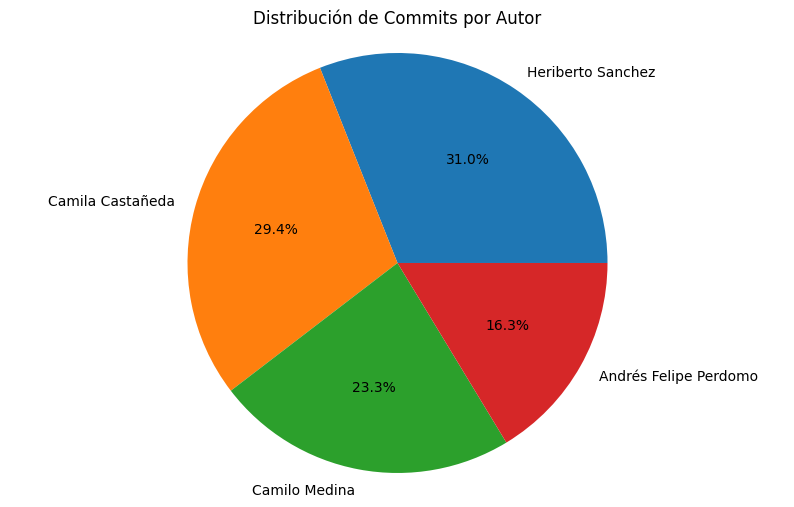

<Figure size 1200x600 with 0 Axes>

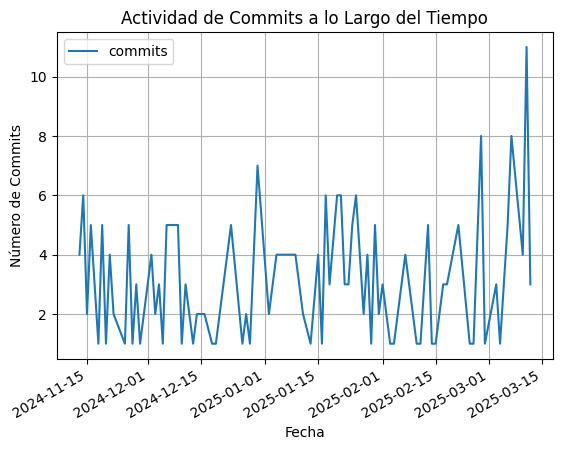

<Figure size 1000x600 with 0 Axes>

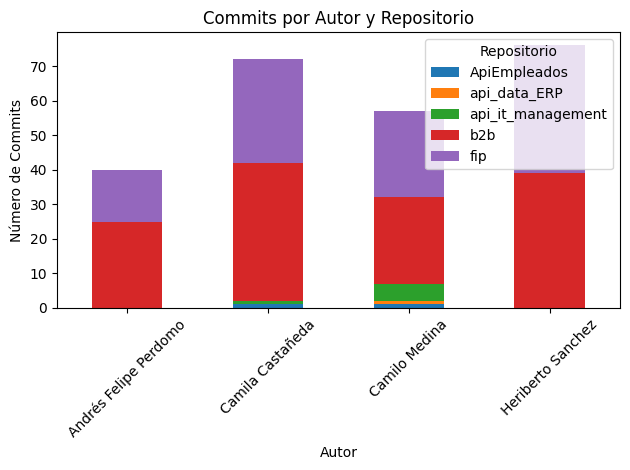

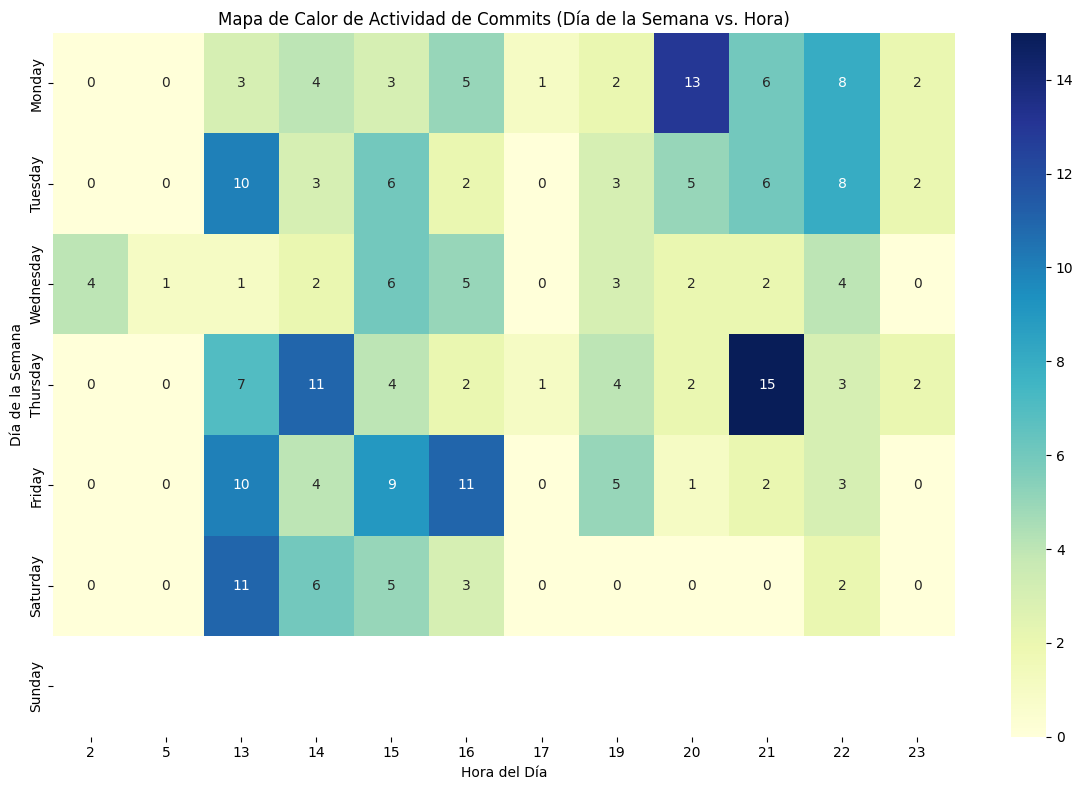


Perspectivas:
- Período de análisis: 118 días (2024-11-13 a 2025-03-12)
- Colaborador más activo: Heriberto Sanchez con 76 commits (31.02% del total)
- Promedio de commits por día: 3.10
- El día más activo tuvo 11 commits
- Repositorio más activo: b2b con 129 commits
- Días sin actividad de commits: 41 (34.2% de los días)


In [223]:
# Mostrar las estadísticas resumidas
print("Análisis de Actividad de Commits")
print("=======================")
display(commit_stats)

# 1. Distribución de commits por autor (gráfica circular)
plt.figure(figsize=(10, 6))
plt.pie(commit_stats["total_commits"], labels=commit_stats["author"], autopct="%1.1f%%")
plt.title("Distribución de Commits por Autor")
plt.axis("equal")
plt.show()

# 2. Commits a lo largo del tiempo
plt.figure(figsize=(12, 6))
time_series = df_commits.groupby("day").size().reset_index(name="commits")
time_series.set_index("day", inplace=True)
time_series.plot()
plt.title("Actividad de Commits a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Número de Commits")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

# 3. Commits por autor y repositorio
plt.figure(figsize=(10, 6))
repo_commits_plot = (
    df_commits.groupby(["author", "repository"]).size().unstack().fillna(0)
)
repo_commits_plot.plot(kind="bar", stacked=True)
plt.title("Commits por Autor y Repositorio")
plt.xlabel("Autor")
plt.ylabel("Número de Commits")
plt.legend(title="Repositorio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Mapa de calor de actividad diaria (día de la semana vs. hora del día)
df_commits["day_of_week"] = df_commits["date"].dt.day_name()
df_commits["hour"] = df_commits["date"].dt.hour

day_hour = df_commits.groupby(["day_of_week", "hour"]).size().unstack().fillna(0)
# Reordenar días
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
day_hour = day_hour.reindex(day_order)

plt.figure(figsize=(12, 8))
if has_seaborn:
    sns.heatmap(day_hour, cmap="YlGnBu", annot=True, fmt="g")
else:
    # Mapa de calor alternativo usando matplotlib
    plt.imshow(day_hour, cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Cantidad de Commits")

    # Agregar anotaciones
    for i in range(day_hour.shape[0]):
        for j in range(day_hour.shape[1]):
            if not pd.isna(day_hour.iloc[i, j]) and day_hour.iloc[i, j] > 0:
                plt.text(
                    j,
                    i,
                    int(day_hour.iloc[i, j]),
                    ha="center",
                    va="center",
                    color="black",
                )

    plt.yticks(range(len(day_hour.index)), day_hour.index)
    plt.xticks(range(len(day_hour.columns)), day_hour.columns)

plt.title("Mapa de Calor de Actividad de Commits (Día de la Semana vs. Hora)")
plt.xlabel("Hora del Día")
plt.ylabel("Día de la Semana")
plt.tight_layout()
plt.show()

# Resumen de perspectivas
recent_date = df_commits["date"].max()
oldest_date = df_commits["date"].min()
analysis_period = (recent_date - oldest_date).days

print("\nPerspectivas:")
print(
    f"- Período de análisis: {analysis_period} días ({oldest_date.date()} a {recent_date.date()})"
)
print(
    f"- Colaborador más activo: {commit_stats['author'].iloc[0]} con {commit_stats['total_commits'].iloc[0]} commits ({commit_stats['percentage'].iloc[0]}% del total)"
)
print(f"- Promedio de commits por día: {df_commits.groupby('day').size().mean():.2f}")
print(f"- El día más activo tuvo {df_commits.groupby('day').size().max()} commits")

# Repositorio con más actividad
repo_activity = df_commits.groupby("repository").size().reset_index(name="commits")
most_active_repo = repo_activity.sort_values("commits", ascending=False).iloc[0]
print(
    f"- Repositorio más activo: {most_active_repo['repository']} con {most_active_repo['commits']} commits"
)

# Calcular días sin commits
all_days = pd.date_range(start=oldest_date.date(), end=recent_date.date())
commit_days = df_commits["day"].unique()
days_no_commits = len(all_days) - len(commit_days)
print(
    f"- Días sin actividad de commits: {days_no_commits} ({days_no_commits / len(all_days) * 100:.1f}% de los días)"
)

### 2. Tamaño de los Commits

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\1421156652.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_commits["has_emoji_prefix"] = df_commits["message"].str.contains(pattern, regex=True)
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\1421156652.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_commits.groupby(["author", "size_category"]).size().unstack().fillna(0)


<Figure size 1200x600 with 0 Axes>

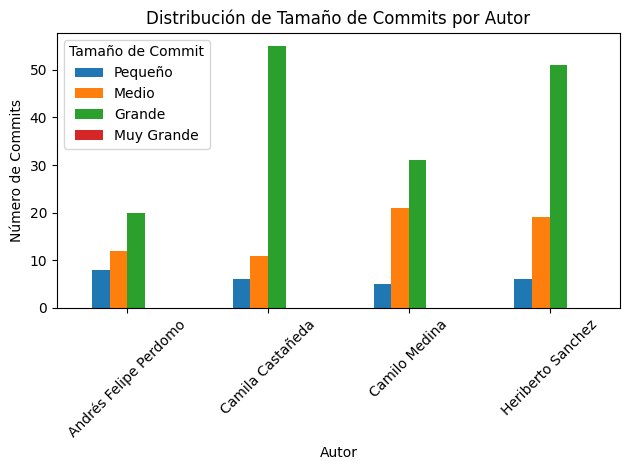

<Figure size 1200x600 with 0 Axes>

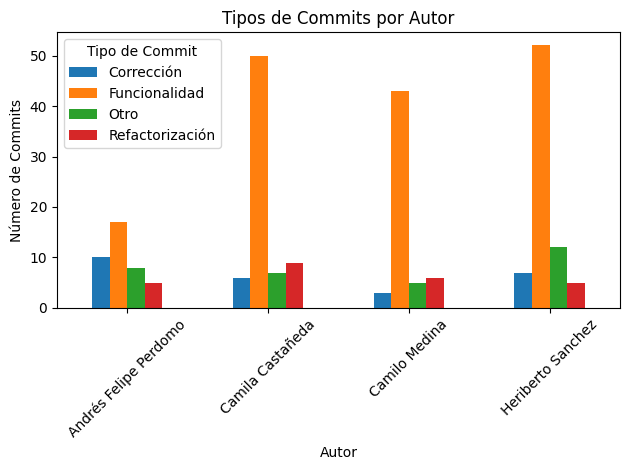


Resumen del Tamaño de Commits:
size_category          Pequeño  Medio  Grande  Muy Grande
author                                                   
Andrés Felipe Perdomo        8     12      20           0
Camila Castañeda             6     11      55           0
Camilo Medina                5     21      31           0
Heriberto Sanchez            6     19      51           0

Distribución por Tipo de Commit:
commit_type            Corrección  Funcionalidad  Otro  Refactorización
author                                                                 
Andrés Felipe Perdomo          10             17     8                5
Camila Castañeda                6             50     7                9
Camilo Medina                   3             43     5                6
Heriberto Sanchez               7             52    12                5

Longitud media de mensaje de commit: 148.0 caracteres
Desviación estándar: 53.8 caracteres
Umbral para commits grandes: 255.6 caracteres

Commits potenci

In [224]:
# Extender el análisis de commits para incluir tamaño (líneas agregadas/eliminadas)

# Verificar si las columnas necesarias existen en df_commits
if "message" not in df_commits.columns:
    print(
        "La columna 'message' no está disponible para analizar el contenido de los commits"
    )
    # Podríamos intentar obtener estos datos con solicitudes adicionales

# Crear categorías de tamaño basadas en heurísticas
# 1. Extraer información del tamaño de los mensajes (como aproximación)
df_commits["msg_length"] = df_commits["message"].str.len()

# 2. Clasificar los commits por tamaño estimado basado en el mensaje
df_commits["size_category"] = pd.cut(
    df_commits["msg_length"],
    bins=[0, 50, 150, 500, float("inf")],
    labels=["Pequeño", "Medio", "Grande", "Muy Grande"],
)

# 3. Analizar el tipo de commit basado en prefijos comunes
pattern = r"^(🐞|🧪|🚀|✅|🔧|📝)"
df_commits["has_emoji_prefix"] = df_commits["message"].str.contains(pattern, regex=True)
df_commits["commit_type"] = "Otro"
df_commits.loc[
    df_commits["message"].str.contains(r"(?i)fix|🐞", na=False), "commit_type"
] = "Corrección"
df_commits.loc[
    df_commits["message"].str.contains(r"(?i)feat|🧪", na=False), "commit_type"
] = "Funcionalidad"
df_commits.loc[
    df_commits["message"].str.contains(r"(?i)refactor|🚀", na=False), "commit_type"
] = "Refactorización"
df_commits.loc[
    df_commits["message"].str.contains(r"(?i)docs|📝", na=False), "commit_type"
] = "Documentación"

# 4. Analizar patrones de commits por autor
size_by_author = (
    df_commits.groupby(["author", "size_category"]).size().unstack().fillna(0)
)
type_by_author = (
    df_commits.groupby(["author", "commit_type"]).size().unstack().fillna(0)
)

# 5. Visualización de los resultados
plt.figure(figsize=(12, 6))
ax = size_by_author.plot(kind="bar", stacked=False)
plt.title("Distribución de Tamaño de Commits por Autor")
plt.xlabel("Autor")
plt.ylabel("Número de Commits")
plt.xticks(rotation=45)
plt.legend(title="Tamaño de Commit")
plt.tight_layout()
plt.show()

# 6. Distribución de tipos de commits
plt.figure(figsize=(12, 6))
ax = type_by_author.plot(kind="bar", stacked=False)
plt.title("Tipos de Commits por Autor")
plt.xlabel("Autor")
plt.ylabel("Número de Commits")
plt.xticks(rotation=45)
plt.legend(title="Tipo de Commit")
plt.tight_layout()
plt.show()

# 7. Resumen estadístico
print("\nResumen del Tamaño de Commits:")
print(size_by_author.to_string())
print("\nDistribución por Tipo de Commit:")
print(type_by_author.to_string())

# 8. Identificar commits extremadamente grandes o pequeños
avg_length = df_commits["msg_length"].mean()
std_length = df_commits["msg_length"].std()
large_threshold = avg_length + 2 * std_length

print(f"\nLongitud media de mensaje de commit: {avg_length:.1f} caracteres")
print(f"Desviación estándar: {std_length:.1f} caracteres")
print(f"Umbral para commits grandes: {large_threshold:.1f} caracteres\n")

# Commits muy grandes (mensaje extenso puede indicar muchos cambios)
large_commits = df_commits[df_commits["msg_length"] > large_threshold].sort_values(
    by="msg_length", ascending=False
)
if not large_commits.empty:
    print("Commits potencialmente grandes:")
    for _, row in large_commits.head(5).iterrows():
        print(
            f"- Autor: {row['author']}, Mensaje: {row['message'][:50]}... ({row['msg_length']} caracteres)"
        )

### 3. Pull Requests (PR)

#### 3.1 Cantidades y tiempos

##### Procesar los datos y graficar

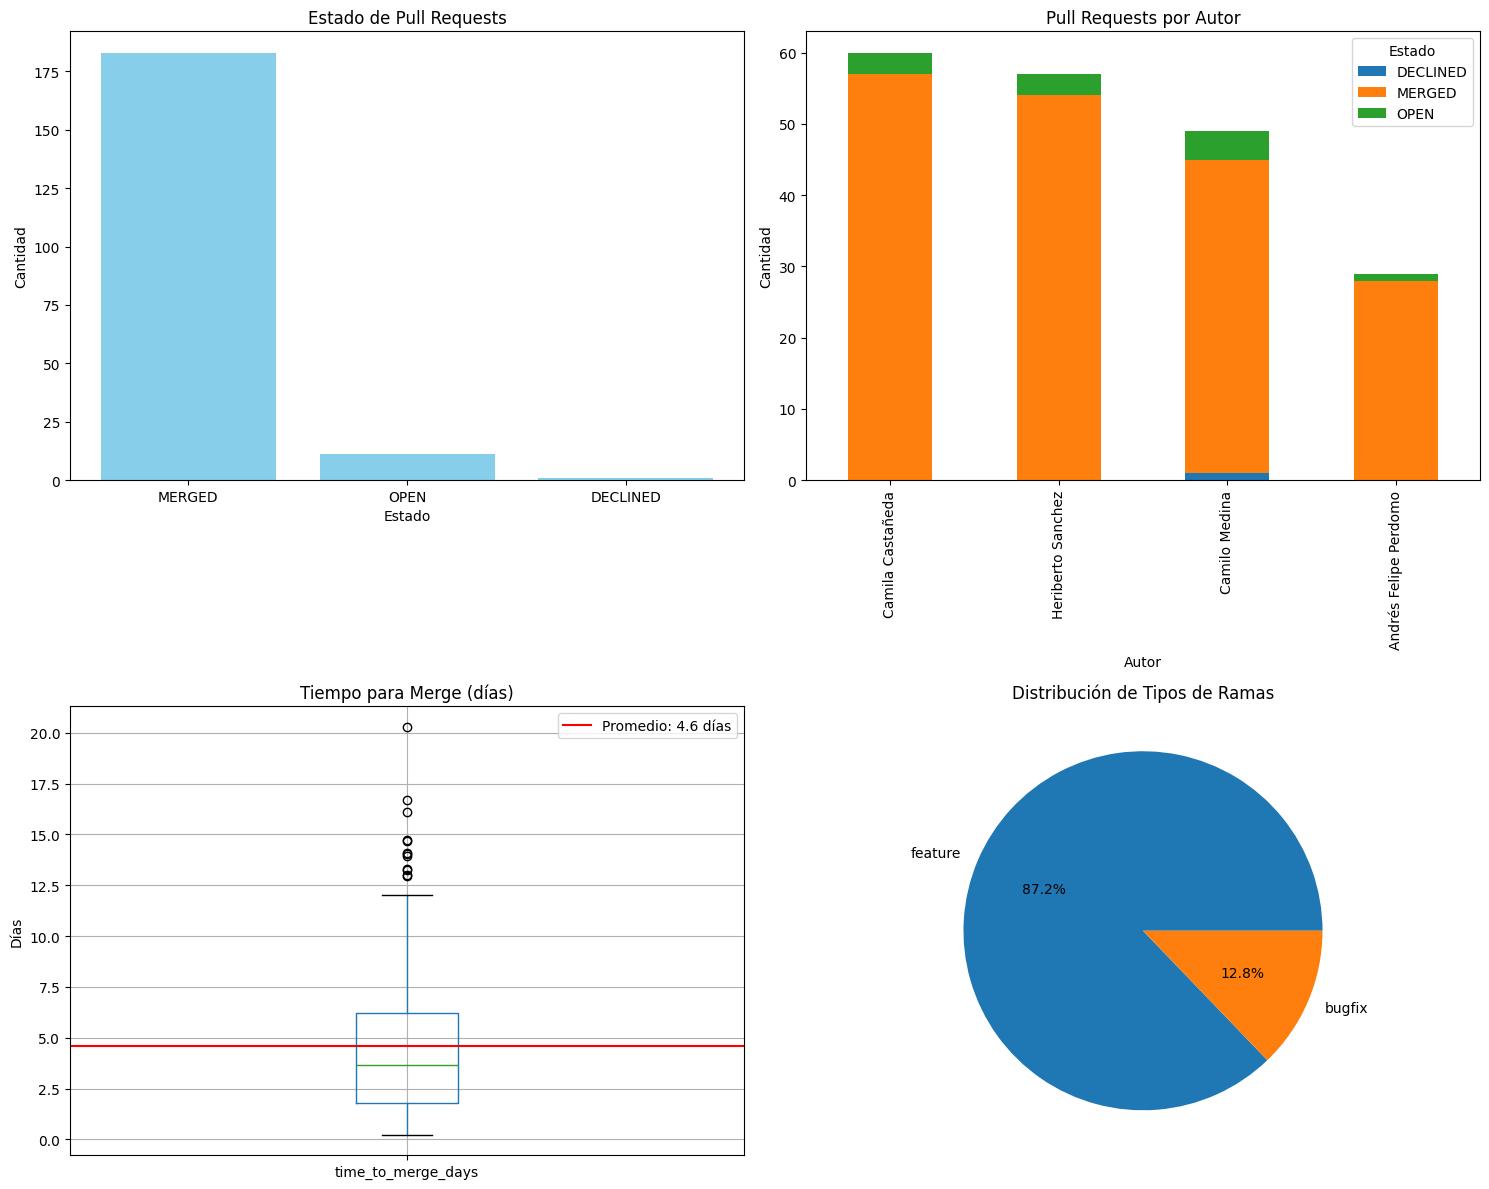


=== Métricas de Pull Requests ===
Total de PRs analizados: 195
PRs por estado: {'MERGED': 183, 'OPEN': 11, 'DECLINED': 1}

Tiempo promedio hasta merge: 4.6 días
Tiempo mediano hasta merge: 3.7 días
Tiempo máximo hasta merge: 20.3 días


C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\309618788.py:140: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  author_efficiency["Tiempo promedio (días)"][i],
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\309618788.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  author_efficiency["PRs mergeados"][i],


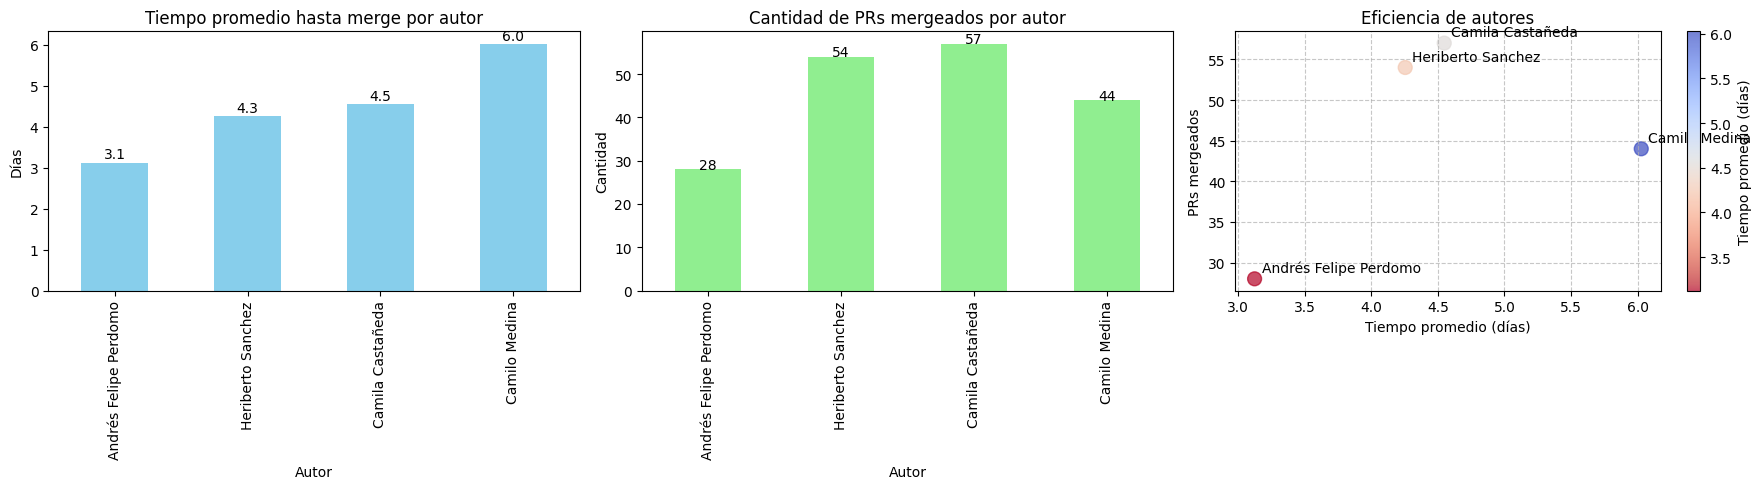


=== Eficiencia de autores (tiempo promedio hasta merge) ===
                       Tiempo promedio (días)  PRs mergeados
author                                                      
Andrés Felipe Perdomo                     3.1             28
Heriberto Sanchez                         4.3             54
Camila Castañeda                          4.5             57
Camilo Medina                             6.0             44


In [225]:
import pandas as pd
# from datetime import datetime

# Análisis de Pull Requests
import matplotlib.pyplot as plt

# Verificar los estados disponibles en los PRs
pr_states = df_pr["state"].value_counts().reset_index()
pr_states.columns = ["Estado", "Cantidad"]

# Analizar PR por autor
pr_by_author = df_pr.groupby(["author", "state"]).size().unstack().fillna(0)
if "MERGED" in pr_by_author.columns:
    pr_by_author["total"] = pr_by_author.sum(axis=1)
    pr_by_author = pr_by_author.sort_values("total", ascending=False)
    pr_by_author = pr_by_author.drop(columns=["total"])

# Calcular tiempos promedio
df_pr["created_on"] = pd.to_datetime(df_pr["created_on"])
df_pr["updated_on"] = pd.to_datetime(df_pr["updated_on"])

# Métricas de tiempo para PRs cerrados/mergeados
merged_prs = df_pr[df_pr["state"] == "MERGED"].copy()
if not merged_prs.empty:
    merged_prs["time_to_merge_days"] = (
        merged_prs["updated_on"] - merged_prs["created_on"]
    ).dt.total_seconds() / 86400
    avg_merge_time = merged_prs["time_to_merge_days"].mean()
    median_merge_time = merged_prs["time_to_merge_days"].median()
    max_merge_time = merged_prs["time_to_merge_days"].max()

# Extraer tipos de ramas de los PRs
branch_types = df_pr["type_branch"].value_counts().reset_index()
branch_types.columns = ["Tipo", "Cantidad"]


# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 📈 1. Estado de los PRs
axes[0, 0].bar(pr_states["Estado"], pr_states["Cantidad"], color="skyblue")
axes[0, 0].set_title("Estado de Pull Requests")
axes[0, 0].set_xlabel("Estado")
axes[0, 0].set_ylabel("Cantidad")

# 📈 2. PRs por autor
pr_by_author.plot(kind="bar", stacked=True, ax=axes[0, 1])
axes[0, 1].set_title("Pull Requests por Autor")
axes[0, 1].set_xlabel("Autor")
axes[0, 1].set_ylabel("Cantidad")
axes[0, 1].legend(title="Estado")


# 📈 3. Tiempo de resolución de PRs
if not merged_prs.empty:
    merged_prs.boxplot(column="time_to_merge_days", ax=axes[1, 0])
    axes[1, 0].set_title("Tiempo para Merge (días)")
    axes[1, 0].set_ylabel("Días")

    # Añadir una línea para el promedio
    axes[1, 0].axhline(
        y=avg_merge_time,
        color="red",
        linestyle="-",
        label=f"Promedio: {avg_merge_time:.1f} días",
    )
    axes[1, 0].legend()

# 📈 4. Tipos de ramas
axes[1, 1].pie(branch_types["Cantidad"], labels=branch_types["Tipo"], autopct="%1.1f%%")
axes[1, 1].set_title("Distribución de Tipos de Ramas")

plt.tight_layout()
plt.show()

# Métricas adicionales
print("\n=== Métricas de Pull Requests ===")
print(f"Total de PRs analizados: {len(df_pr)}")
print(f"PRs por estado: {dict(pr_states.values)}")
if not merged_prs.empty:
    print(f"\nTiempo promedio hasta merge: {avg_merge_time:.1f} días")
    print(f"Tiempo mediano hasta merge: {median_merge_time:.1f} días")
    print(f"Tiempo máximo hasta merge: {max_merge_time:.1f} días")


# -------------------------------------------------------------


# 📊 Análisis de eficiencia de PRs
if not merged_prs.empty:
    author_efficiency = (
        merged_prs.groupby("author")["time_to_merge_days"]
        .agg(["mean", "count"])
        .sort_values("mean")
    )
    author_efficiency.columns = ["Tiempo promedio (días)", "PRs mergeados"]

    # Crear tres gráficas para visualizar la eficiencia de los autores
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # 📈 Gráfica 1: Tiempo promedio hasta merge
    author_efficiency["Tiempo promedio (días)"].plot(
        kind="bar",
        color="skyblue",
        ax=ax1,
        title="Tiempo promedio hasta merge por autor",
    )
    ax1.set_xlabel("Autor")
    ax1.set_ylabel("Días")
    for i, v in enumerate(author_efficiency["Tiempo promedio (días)"]):
        ax1.text(i, v + 0.1, f"{v:.1f}", ha="center")

    # 📈 Gráfica 2: Cantidad de PRs mergeados
    author_efficiency["PRs mergeados"].plot(
        kind="bar",
        color="lightgreen",
        ax=ax2,
        title="Cantidad de PRs mergeados por autor",
    )
    ax2.set_xlabel("Autor")
    ax2.set_ylabel("Cantidad")
    for i, v in enumerate(author_efficiency["PRs mergeados"]):
        ax2.text(i, v + 0.1, str(v), ha="center")

    # 📈 Gráfica 3: Eficiencia general de los autores
    scatter = ax3.scatter(
        author_efficiency["Tiempo promedio (días)"],
        author_efficiency["PRs mergeados"],
        s=100,
        alpha=0.7,
        c=author_efficiency["Tiempo promedio (días)"],
        cmap="coolwarm_r",
    )

    # Añadir etiquetas a cada punto
    for i, author in enumerate(author_efficiency.index):
        ax3.annotate(
            author,
            (
                author_efficiency["Tiempo promedio (días)"][i],
                author_efficiency["PRs mergeados"][i],
            ),
            xytext=(5, 5),
            textcoords="offset points",
        )

    ax3.set_title("Eficiencia de autores")
    ax3.set_xlabel("Tiempo promedio (días)")
    ax3.set_ylabel("PRs mergeados")
    ax3.grid(True, linestyle="--", alpha=0.7)

    # Añadir colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label("Tiempo promedio (días)")

    plt.tight_layout()
    plt.show()

    print("\n=== Eficiencia de autores (tiempo promedio hasta merge) ===")
    print(author_efficiency.to_string(float_format=lambda x: f"{x:.1f}"))

#### 3.2 Comentarios

##### PRs más largos

In [226]:
# Identificar PRs con tiempos de revisión largos y comentarios numerosos
if "comment_count" in df_pr.columns:
    high_discussion = df_pr.sort_values("comment_count", ascending=False).head(5)
    print("\n=== PRs con más discusión (mayor número de comentarios) ===")
    high_discussion["formatted_date"] = high_discussion["created_on"].dt.strftime(
        "%d-%m-%Y"
    )
    print(
        pd.DataFrame(
            {
                "Título": high_discussion["title"],
                "Autor": high_discussion["author"],
                "Comentarios": high_discussion["comment_count"],
                "Estado": high_discussion["state"],
                "Fecha": high_discussion["formatted_date"],
            }
        ).to_string()
    )



=== PRs con más discusión (mayor número de comentarios) ===
                                                                                      Título              Autor  Comentarios  Estado       Fecha
181                               🧪Feat: Ajusta estados del modulo prefactibilidad (CPK-738)      Camilo Medina           34  MERGED  02-12-2024
180                   🧪Feat: Crea tabla y endpoints para los movimientos contables (CPK-860)  Heriberto Sanchez           31  MERGED  05-12-2024
35   🧪Feat: Implementa validaciones de datos en los endpoints tipo PUT en usuarios (BTB-697)      Camilo Medina           23  MERGED  29-01-2025
151         🧪Feat: Crea endpoints y migración para la parametrización de variables (CPK-896)   Camila Castañeda           23  MERGED  20-01-2025
136            🧪Feat: Crea migración para ajustar tablas relacionadas con recaudos (CPK-618)      Camilo Medina           22  MERGED  13-02-2025


##### Procesar los datos (primeras 3 gráficas)

In [227]:
import pandas as pd
# from datetime import timedelta

import matplotlib.pyplot as plt

# Parámetro configurable: número de días a analizar
num_days_to_analyze = 25

# Calcular fecha límite
today = pd.Timestamp.now(tz="America/Bogota")
date_limit = today - pd.Timedelta(days=num_days_to_analyze)

# Asegurar que la columna de fecha está en el formato correcto
df_pr["created_on"] = pd.to_datetime(df_pr["created_on"])

# Filtrar PRs por fecha
recent_prs = df_pr[df_pr["created_on"] >= date_limit]

# Crear una lista de todas las fechas en el rango analizado
date_range = pd.date_range(start=date_limit, end=today, freq="D")
date_range = [d.date() for d in date_range]

# Contar PRs por día
prs_by_day = recent_prs.groupby(recent_prs["created_on"].dt.date).size()

# Asegurar que tenemos todas las fechas (incluso las que no tienen PRs)
prs_by_day = prs_by_day.reindex(date_range, fill_value=0)

##### Graficar

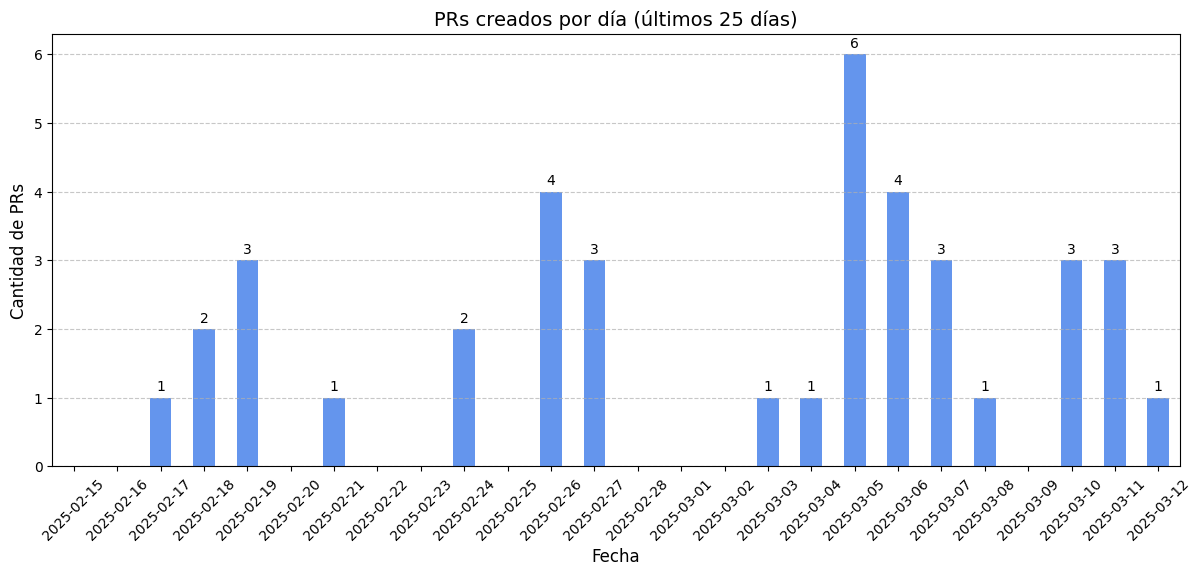

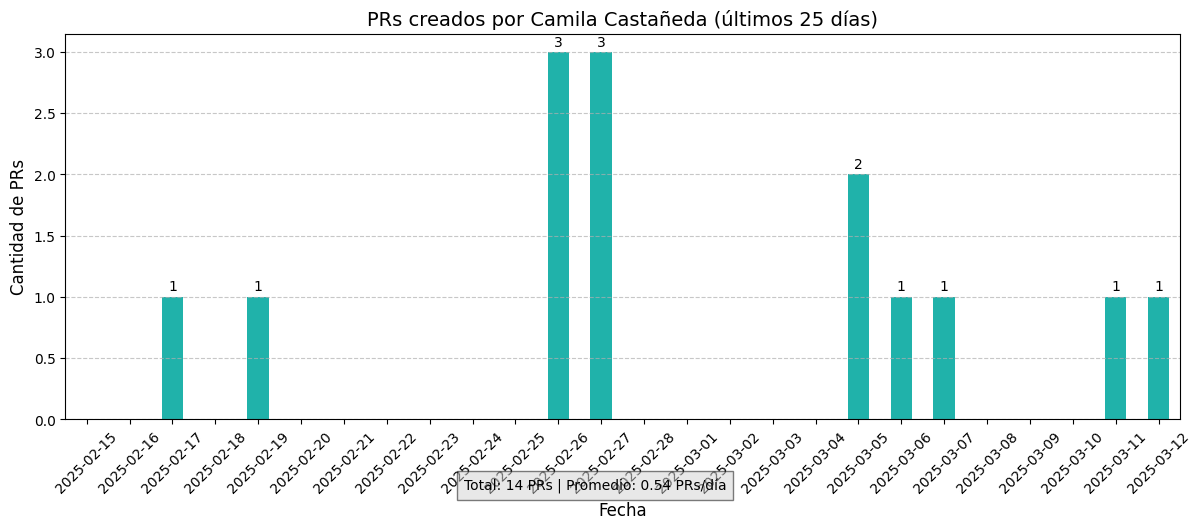

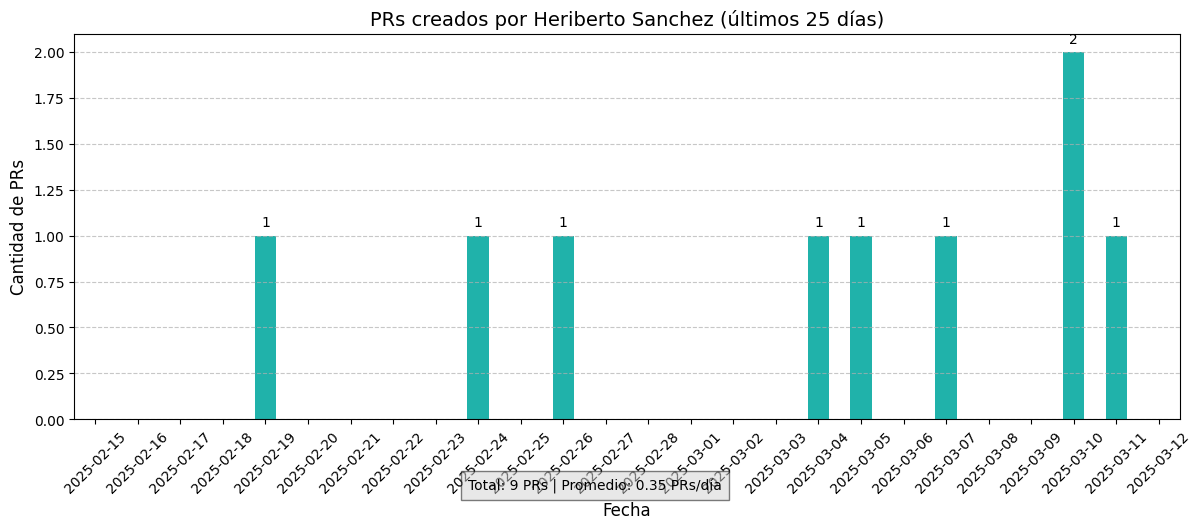

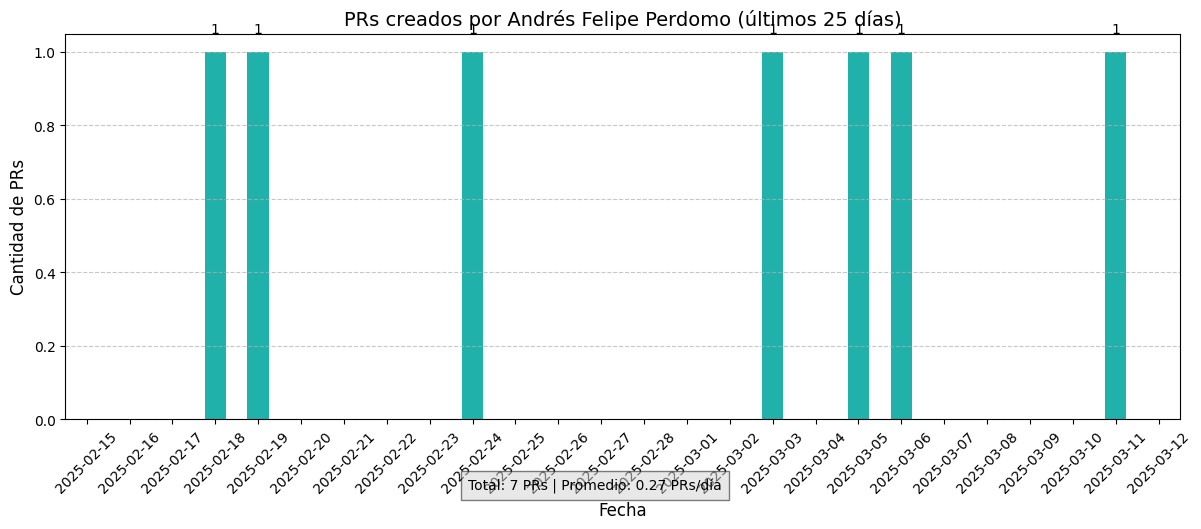

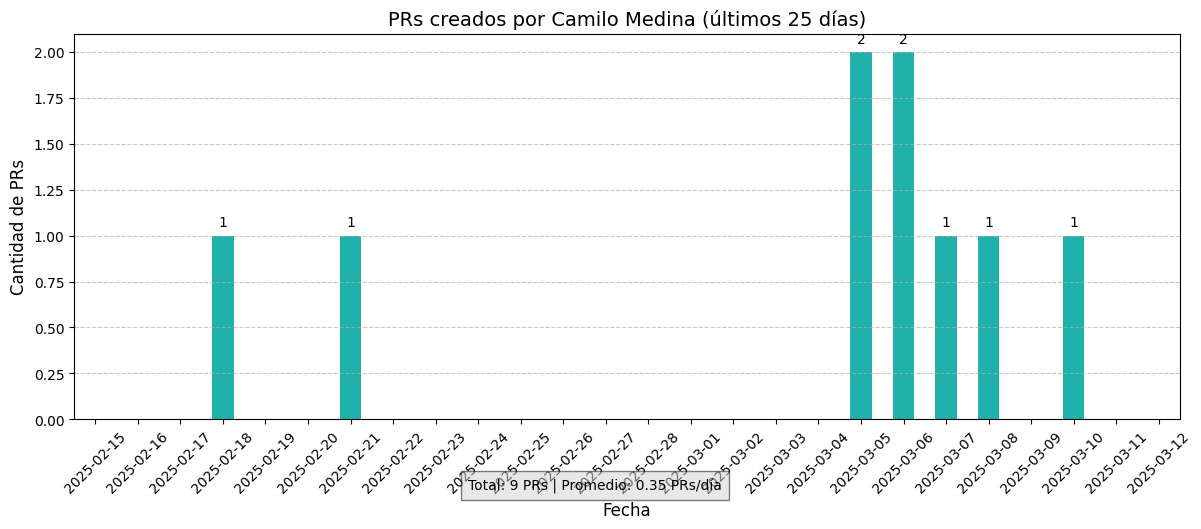

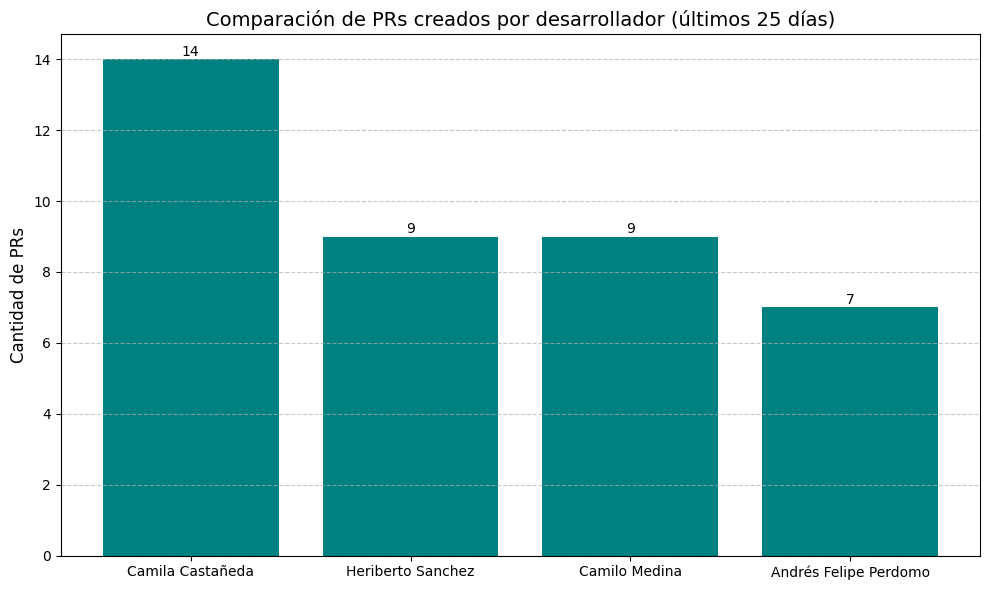

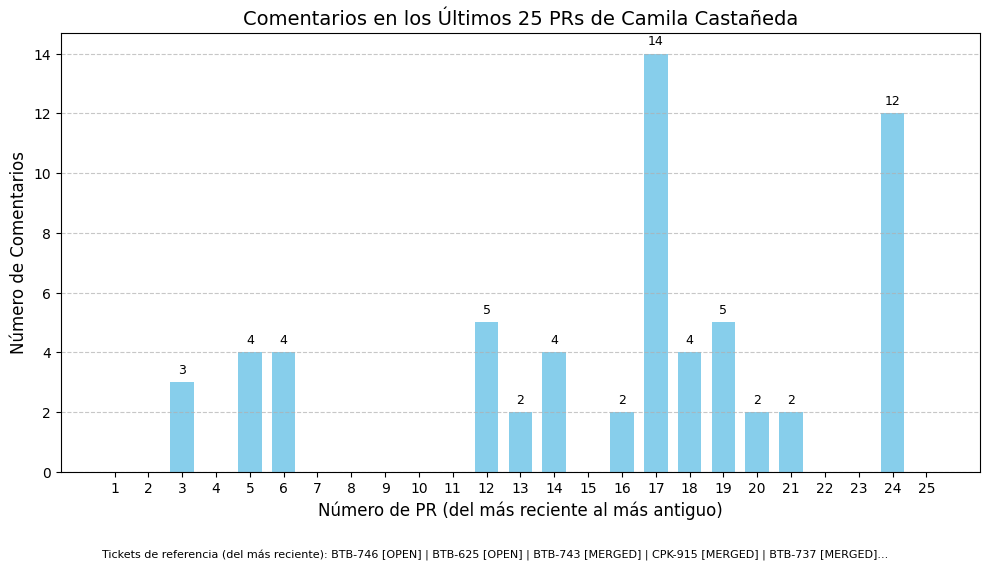

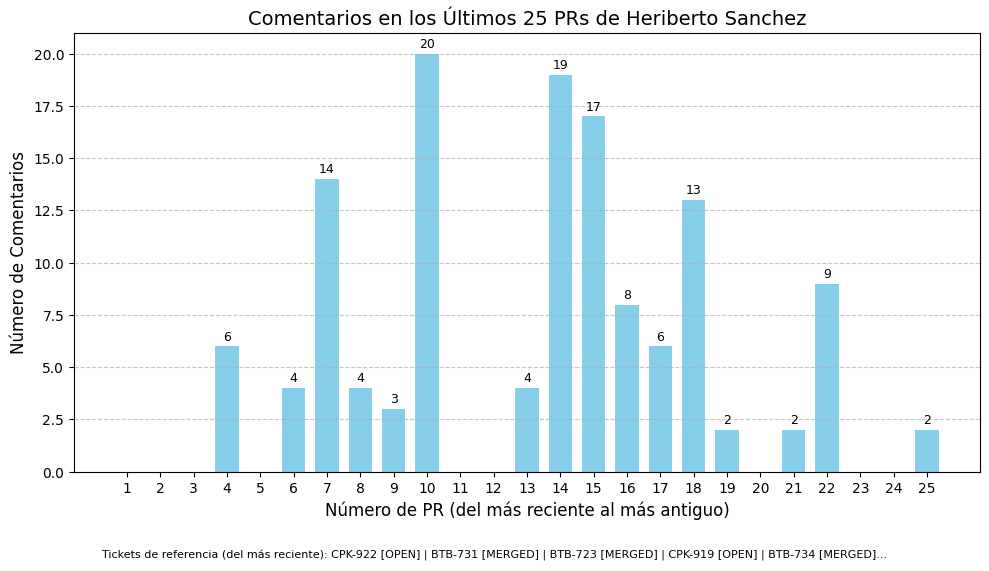

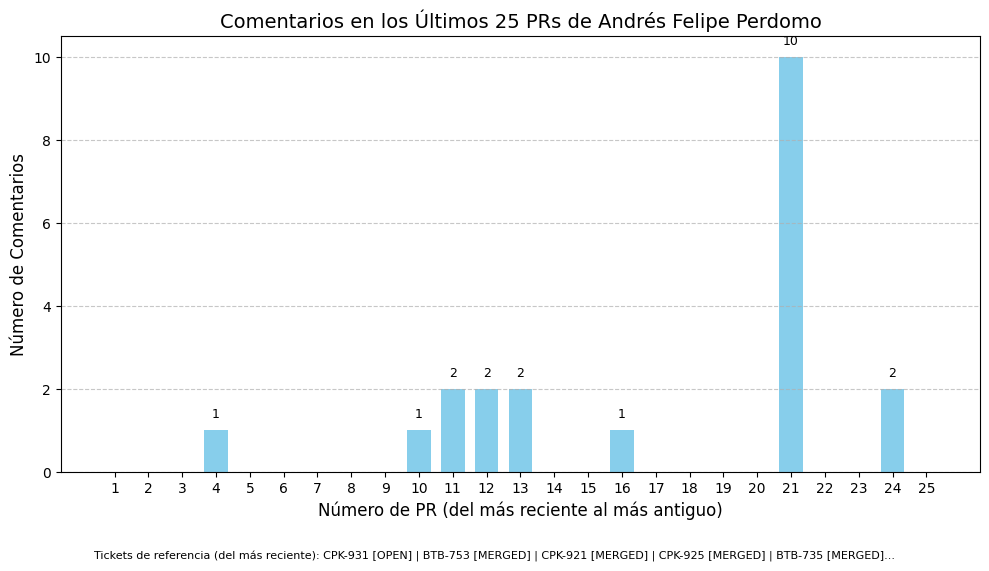

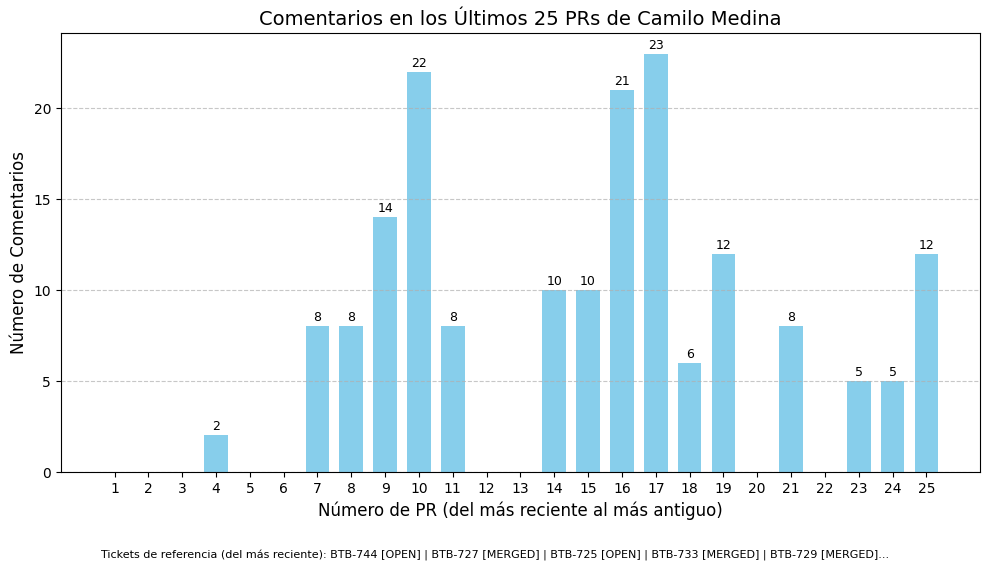

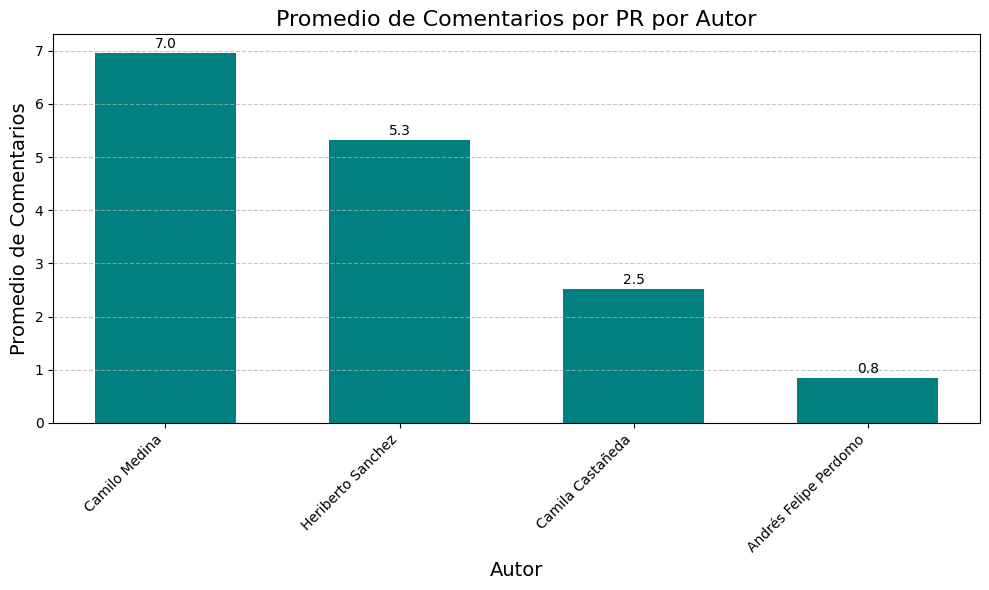

In [228]:
import numpy as np

# 📈 1. Gráfico general de PRs por día
plt.figure(figsize=(12, 6))
prs_by_day.plot(kind="bar", color="cornflowerblue")
plt.title(f"PRs creados por día (últimos {num_days_to_analyze} días)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Cantidad de PRs", fontsize=12)

# Añadir etiquetas de valor sobre cada barra
for i, value in enumerate(prs_by_day):
    if value > 0:
        plt.text(i, value + 0.1, str(int(value)), ha="center")

plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# 📈 2. Gráficos individuales por desarrollador
# Obtener lista de desarrolladores
developers = recent_prs["author"].unique()

for dev in developers:
    # Filtrar PRs de este desarrollador
    dev_prs = recent_prs[recent_prs["author"] == dev]

    # Contar PRs por día para este desarrollador
    dev_prs_by_day = dev_prs.groupby(dev_prs["created_on"].dt.date).size()

    # Asegurar que tenemos todas las fechas (incluso las que no tienen PRs)
    dev_prs_by_day = dev_prs_by_day.reindex(date_range, fill_value=0)

    # Crear gráfico para este desarrollador
    plt.figure(figsize=(12, 5))
    ax = dev_prs_by_day.plot(kind="bar", color="lightseagreen")
    plt.title(
        f"PRs creados por {dev} (últimos {num_days_to_analyze} días)", fontsize=14
    )
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Cantidad de PRs", fontsize=12)

    # Añadir etiquetas de valor sobre cada barra
    for i, value in enumerate(dev_prs_by_day):
        if value > 0:
            plt.text(i, value + 0.05, str(int(value)), ha="center")

    # Añadir información adicional
    total_prs = dev_prs_by_day.sum()
    avg_prs = dev_prs_by_day.mean()
    plt.figtext(
        0.5,
        0.01,
        f"Total: {int(total_prs)} PRs | Promedio: {avg_prs:.2f} PRs/día",
        ha="center",
        fontsize=10,
        bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
    )

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.subplots_adjust(bottom=0.15)
    plt.show()


# 📈 3. Gráfico comparativo entre desarrolladores
dev_comparison = pd.DataFrame(
    {
        "Desarrollador": developers,
        "Total PRs": [
            len(recent_prs[recent_prs["author"] == dev]) for dev in developers
        ],
    }
).sort_values("Total PRs", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(
    dev_comparison["Desarrollador"], dev_comparison["Total PRs"], color="teal"
)

# Añadir etiquetas de valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.1,
        f"{int(height)}",
        ha="center",
        fontsize=10,
    )

plt.title(
    f"Comparación de PRs creados por desarrollador (últimos {num_days_to_analyze} días)",
    fontsize=14,
)
plt.ylabel("Cantidad de PRs", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Define the number of PRs to display per author
num_prs_to_display = num_days_to_analyze  # This can be changed to any value as needed

# Filtrar los últimos PRs para cada autor (basado en la variable)
author_prs = {}
for author in df_pr["author"].unique():
    # Obtener los últimos N PRs de este autor
    latest_prs = (
        df_pr[df_pr["author"] == author]
        .sort_values("created_on", ascending=False)
        .head(num_prs_to_display)
    )

    if not latest_prs.empty:
        author_prs[author] = latest_prs

# Crear una figura para cada autor
for author, prs in author_prs.items():
    # Configurar el gráfico para este autor
    fig, ax = plt.subplots(figsize=(10, 6))

    # Preparar datos para este autor
    comment_counts = []
    pr_titles = []
    actual_count = min(len(prs), num_prs_to_display)

    # Obtener datos para las barras
    for j in range(actual_count):
        comment_counts.append(prs.iloc[j]["comment_count"])
        pr_titles.append(f"{j + 1}")

    # Crear posiciones para las barras
    positions = np.arange(len(comment_counts))

    # Graficar barras para este autor
    bars = ax.bar(positions, comment_counts, color="skyblue", width=0.7)

    # Añadir etiquetas con el número de comentarios encima de cada barra
    for bar, count in zip(bars, comment_counts):
        if count > 0:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.3,
                str(int(count)),
                ha="center",
                fontsize=9,
            )

    # Configuración adicional del gráfico
    ax.set_title(
        f"Comentarios en los Últimos {actual_count} PRs de {author}",
        fontsize=14,
    )
    ax.set_xlabel(
        "Número de PR (del más reciente al más antiguo)",
        fontsize=12,
    )
    ax.set_ylabel("Número de Comentarios", fontsize=12)
    ax.set_xticks(positions)
    ax.set_xticklabels(pr_titles)

    # Añadir una referencia al número de ticket y estado en la parte inferior
    if actual_count > 0:
        ticket_info = []
        for j in range(actual_count):
            pr = prs.iloc[j]
            # Extraer el código del ticket (BTB-XXX) del título si existe
            title = pr["title"]
            ticket_code = ""
            import re

            match = re.search(r"\(([A-Z]+-\d+)\)", title) or re.search(
                r"\s([A-Z]+-\d+)", title
            )
            if match:
                ticket_code = match.group(1)
            else:
                # Intentar extraer cualquier código con formato BTB-XXX
                match = re.search(r"([A-Z]+-\d+)", title)
                if match:
                    ticket_code = match.group(1)

            state_info = f"[{pr['state']}]"
            ticket_info.append(f"{ticket_code} {state_info}")

        # Añadir anotaciones con información del ticket
        plt.figtext(
            0.5,
            0.01,
            "Tickets de referencia (del más reciente): "
            + " | ".join(ticket_info[:5])
            + ("..." if len(ticket_info) > 5 else ""),
            ha="center",
            fontsize=8,
            wrap=True,
        )

    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout(
        rect=[0, 0.05, 1, 0.95]
    )  # Dejar espacio para la anotación inferior
    plt.show()


# ----------------------------------


# 📈 Crear gráfica comparativa del promedio de comentarios por PR por autor
plt.figure(figsize=(10, 6))

# Calcular el promedio de comentarios por autor
avg_comments_by_author = {}
for author, prs in author_prs.items():
    avg_comments = prs["comment_count"].mean()
    avg_comments_by_author[author] = avg_comments

# Ordenar los autores por promedio de comentarios (descendente)
sorted_authors = sorted(
    avg_comments_by_author.items(), key=lambda x: x[1], reverse=True
)
authors = [item[0] for item in sorted_authors]
avg_values = [item[1] for item in sorted_authors]

# Crear barras
positions = np.arange(len(authors))
bars = plt.bar(positions, avg_values, color="teal", width=0.6)

# Añadir etiquetas con el valor promedio
for bar, value in zip(bars, avg_values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.1,
        f"{value:.1f}",
        ha="center",
        fontsize=10,
    )

# Configurar gráfico
plt.title("Promedio de Comentarios por PR por Autor", fontsize=16)
plt.xlabel("Autor", fontsize=14)
plt.ylabel("Promedio de Comentarios", fontsize=14)
plt.xticks(positions, authors, rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### 4. Revisión de Código

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\677860608.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_analysis["has_comments"] = comment_analysis["comment_count"] > 0


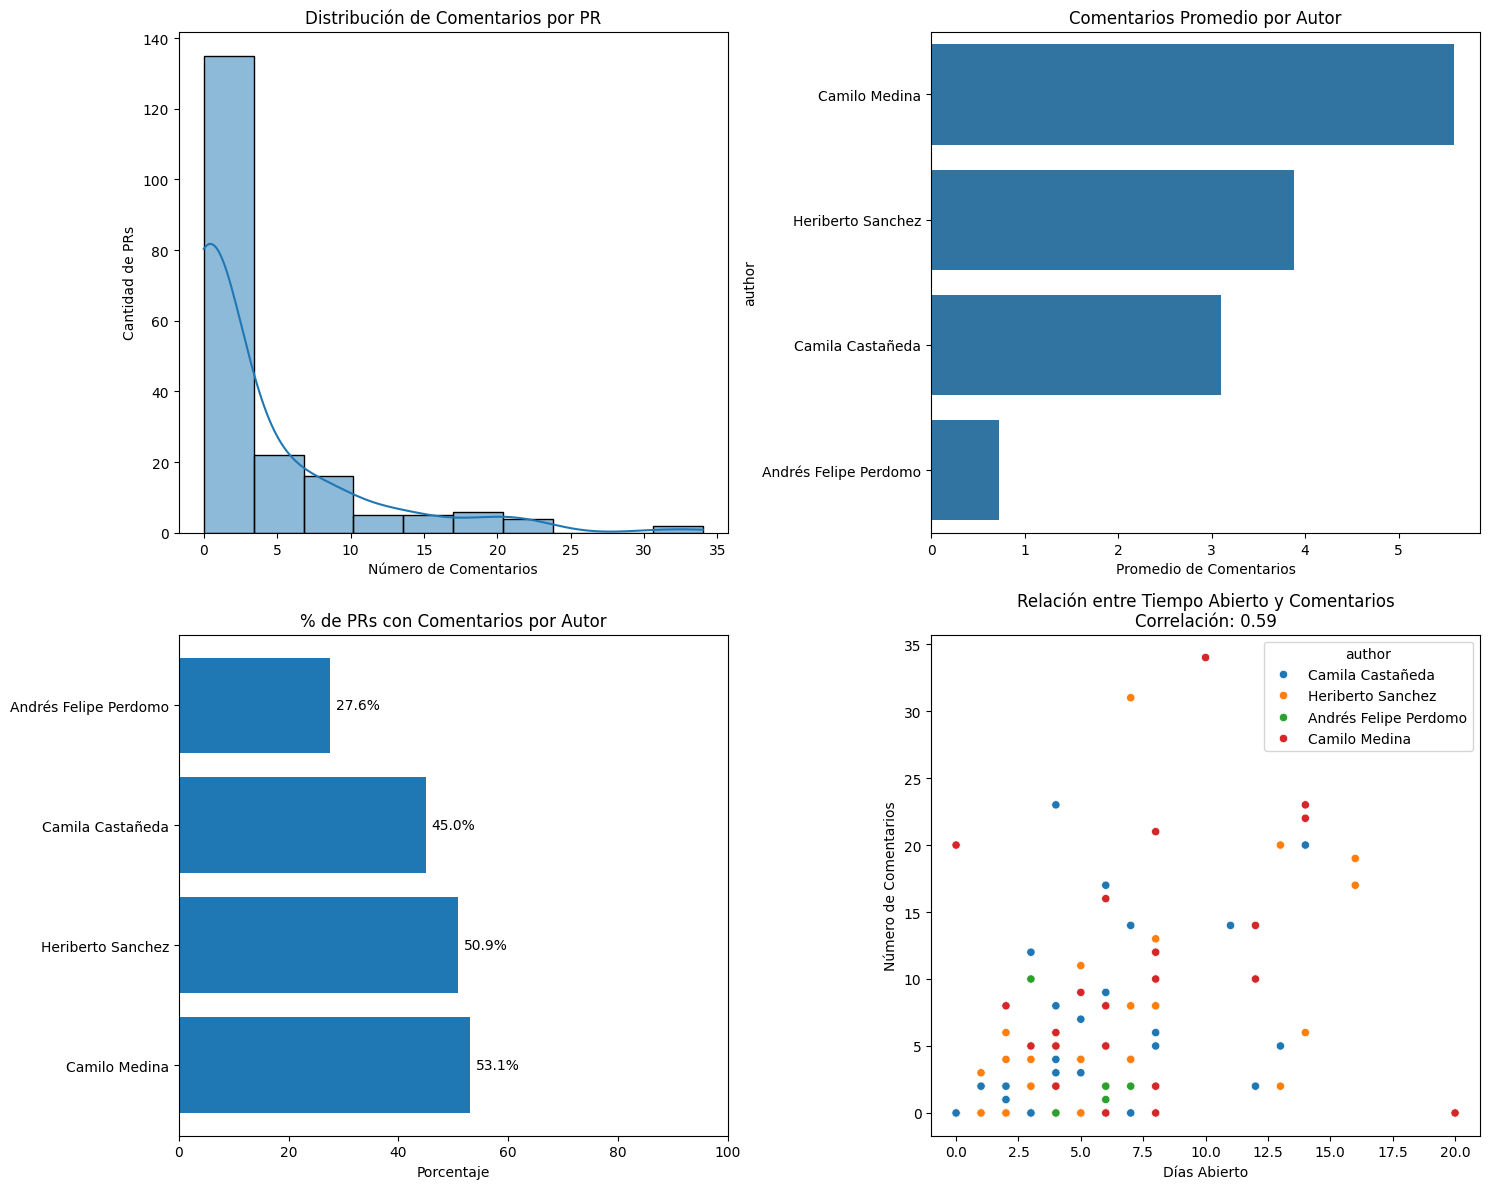


=== Estadísticas de Revisión de Código ===
PRs con al menos un comentario: 46.2%
Comentarios promedio por PR: 3.60

Comentarios por estado de PR:
               mean  median  sum  count
state                                  
DECLINED  20.000000    20.0   20      1
MERGED     3.606557     0.0  660    183
OPEN       2.000000     0.0   22     11

Comentarios por repositorio:
                       mean  median  sum  count
repository                                     
ApiEmpleados       5.000000     5.0    5      1
api_data_ERP       5.000000     5.0    5      1
api_it_management  2.000000     0.0    8      4
b2b                1.692308     0.0  198    117
fip                6.750000     4.5  486     72

=== Análisis de Calidad de Revisión ===
Estadísticas por autor:
                       avg_comments  total_comments  total_prs  \
author                                                           
Camilo Medina              5.591837             274         49   
Heriberto Sanchez       

In [229]:
%pip install seaborn

# import numpy as np
# import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Analizar la calidad de revisión de código basado en los datos de PR
# Extraer datos de comentarios, aprobaciones y estados

# 1. Análisis de comentarios y revisiones por PR
comment_analysis = df_pr[
    ["author", "comment_count", "state", "repository", "days_open"]
]

# 2. Estadísticas de comentarios por estado y repo
comments_by_state = comment_analysis.groupby("state")["comment_count"].agg(
    ["mean", "median", "sum", "count"]
)
comments_by_repo = comment_analysis.groupby("repository")["comment_count"].agg(
    ["mean", "median", "sum", "count"]
)

# 3. Identificar PRs con comentarios vs sin comentarios
comment_analysis["has_comments"] = comment_analysis["comment_count"] > 0
comments_percentage = comment_analysis["has_comments"].mean() * 100

# 4. Análisis por autor (quién recibe más comentarios)
author_comments = comment_analysis.groupby("author").agg(
    {"comment_count": ["mean", "sum", "count"], "has_comments": "mean"}
)
author_comments.columns = [
    "avg_comments",
    "total_comments",
    "total_prs",
    "pct_prs_with_comments",
]
author_comments["pct_prs_with_comments"] = (
    author_comments["pct_prs_with_comments"] * 100
)

# 5. Relación entre tiempo abierto y cantidad de comentarios
correlation = comment_analysis[["days_open", "comment_count"]].corr().iloc[0, 1]

# Visualizaciones
plt.figure(figsize=(15, 12))

# 📈 1. Distribución de comentarios por PR
plt.subplot(2, 2, 1)
sns.histplot(comment_analysis["comment_count"], kde=True, bins=10)
plt.title("Distribución de Comentarios por PR")
plt.xlabel("Número de Comentarios")
plt.ylabel("Cantidad de PRs")

# 📈 2. Comentarios promedio por autor
plt.subplot(2, 2, 2)
author_order = author_comments.sort_values("avg_comments", ascending=False).index
sns.barplot(x=author_comments.loc[author_order, "avg_comments"], y=author_order)
plt.title("Comentarios Promedio por Autor")
plt.xlabel("Promedio de Comentarios")
plt.tight_layout()

# 📈 3. Porcentaje de PRs con comentarios por autor
plt.subplot(2, 2, 3)
author_order = author_comments.sort_values(
    "pct_prs_with_comments", ascending=False
).index
bars = plt.barh(
    author_order, author_comments.loc[author_order, "pct_prs_with_comments"]
)
plt.title("% de PRs con Comentarios por Autor")
plt.xlabel("Porcentaje")
# Añadir etiquetas de valor a las barras
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 1,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        ha="left",
        va="center",
    )
plt.xlim(0, 100)

# 📈 4. Relación entre tiempo abierto y comentarios
plt.subplot(2, 2, 4)
sns.scatterplot(x="days_open", y="comment_count", hue="author", data=comment_analysis)
plt.title(
    f"Relación entre Tiempo Abierto y Comentarios\nCorrelación: {correlation:.2f}"
)
plt.xlabel("Días Abierto")
plt.ylabel("Número de Comentarios")

plt.tight_layout()
plt.show()

# Tabla de estadísticas
print("\n=== Estadísticas de Revisión de Código ===")
print(f"PRs con al menos un comentario: {comments_percentage:.1f}%")
print(f"Comentarios promedio por PR: {comment_analysis['comment_count'].mean():.2f}")
print("\nComentarios por estado de PR:")
print(comments_by_state)
print("\nComentarios por repositorio:")
print(comments_by_repo)

# Análisis de calidad de revisión
print("\n=== Análisis de Calidad de Revisión ===")
print("Estadísticas por autor:")
print(author_comments.sort_values("avg_comments", ascending=False))

# Identificar revisores más activos (estimación basada en comentarios)
# Asumimos que autores que reciben comentarios también hacen comentarios en PRs de otros
active_reviewers = author_comments.sort_values("total_comments", ascending=False)
print("\nRevisores más activos (estimado):")
for author, row in active_reviewers.iterrows():
    print(
        f"- {author}: {row['total_comments']} comentarios totales en {row['total_prs']} PRs"
    )

# Análisis adicional de tiempo de respuesta y eficiencia
merged_prs = df_pr[df_pr["state"] == "MERGED"]
if not merged_prs.empty:
    print(f"\nTiempo promedio hasta merge: {merged_prs['days_open'].mean():.1f} días")
    print(
        f"PRs que recibieron comentarios: {merged_prs['comment_count'].gt(0).mean() * 100:.1f}%"
    )

    # Analizar si los PRs con comentarios tardan más en ser mergeados
    with_comments = merged_prs[merged_prs["comment_count"] > 0]["days_open"].mean()
    without_comments = merged_prs[merged_prs["comment_count"] == 0]["days_open"].mean()
    print(f"Tiempo promedio hasta merge (con comentarios): {with_comments:.1f} días")
    print(f"Tiempo promedio hasta merge (sin comentarios): {without_comments:.1f} días")

### Tiempo de Revisión

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\3529556671.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\3529556671.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)


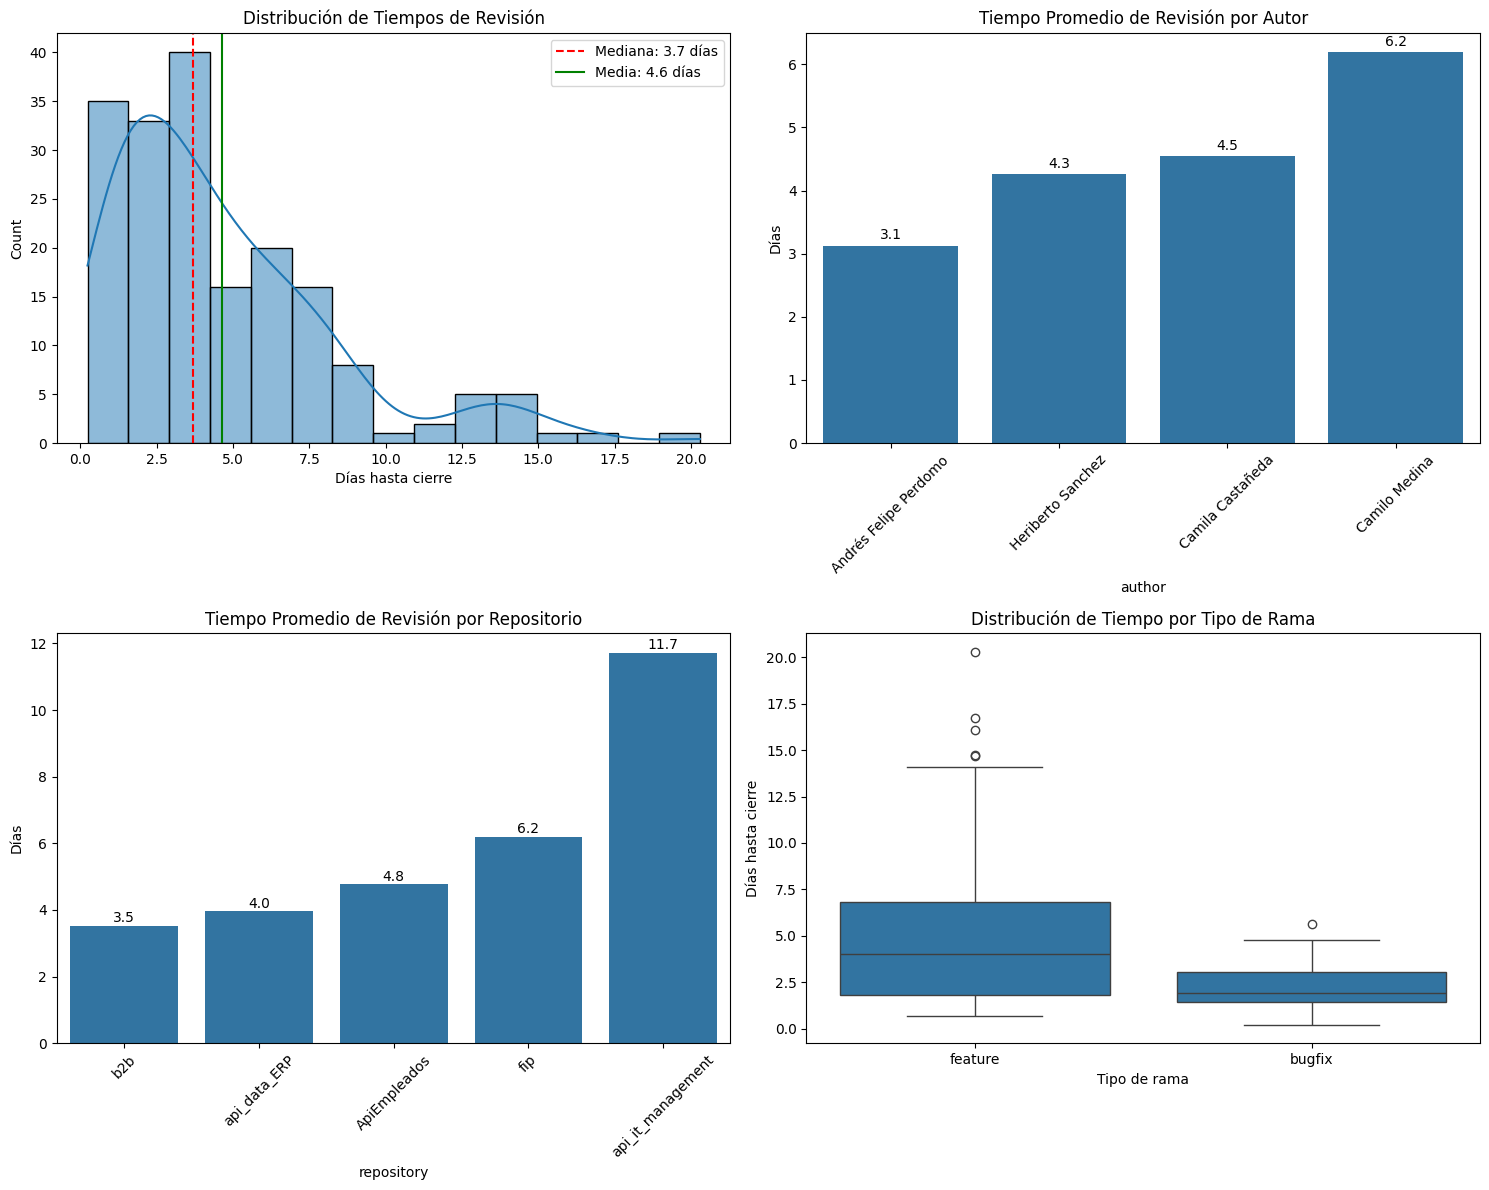

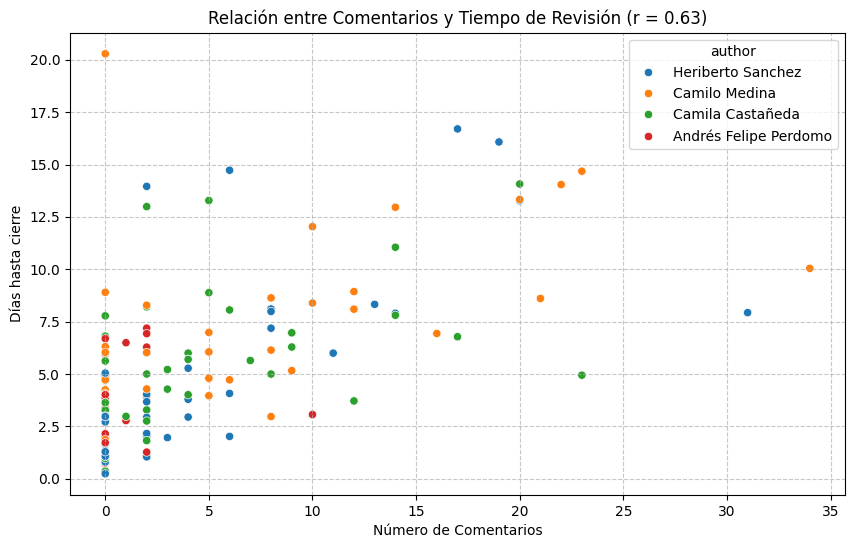

===== ANÁLISIS DE TIEMPO DE REVISIÓN =====

Tiempo promedio global hasta cierre: 4.6 días
Tiempo mediano global hasta cierre: 3.7 días
PRs con tiempo de revisión excesivo (>7 días): 35 (19.0%)

PRs con revisión rápida (≤1 día): 13 (7.1%)
PRs con revisión lenta (≥7 días): 35 (19.0%)


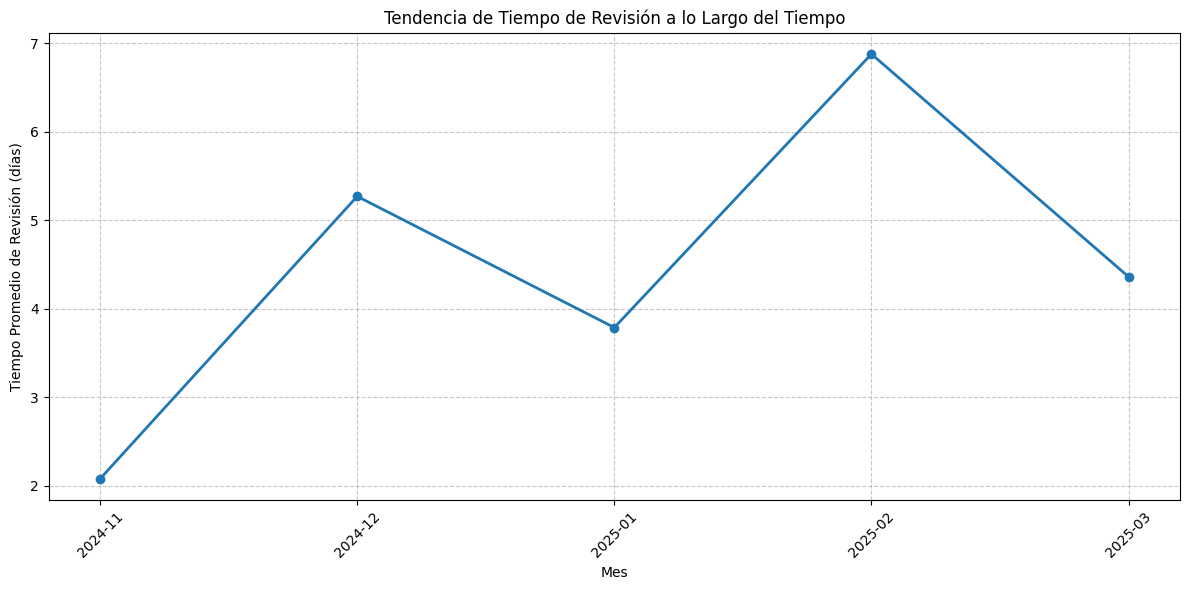

In [230]:
import pandas as pd

# import numpy as np
import seaborn as sns

# Análisis de tiempo desde PR creada hasta merge/cierre
import matplotlib.pyplot as plt

# Asegurar que las fechas están en formato correcto
df_pr["created_on"] = pd.to_datetime(df_pr["created_on"])
df_pr["updated_on"] = pd.to_datetime(df_pr["updated_on"])

# Filtrar PRs que han sido cerradas (merged o declined)
closed_prs = df_pr[df_pr["state"].isin(["MERGED", "DECLINED"])].copy()

if not closed_prs.empty:
    # Calcular tiempo hasta cierre para PRs cerradas
    closed_prs["time_to_close_days"] = (
        closed_prs["updated_on"] - closed_prs["created_on"]
    ).dt.total_seconds() / 86400

    # Analizar por autor, repositorio y tipo de rama
    time_by_author = (
        closed_prs.groupby("author")["time_to_close_days"]
        .agg(["mean", "median", "count"])
        .sort_values("mean")
    )
    time_by_repo = (
        closed_prs.groupby("repository")["time_to_close_days"]
        .agg(["mean", "median", "count"])
        .sort_values("mean")
    )
    time_by_branch_type = (
        closed_prs.groupby("type_branch")["time_to_close_days"]
        .agg(["mean", "median", "count"])
        .sort_values("mean")
    )

    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Distribución general de tiempos de revisión
    sns.histplot(closed_prs["time_to_close_days"], bins=15, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Distribución de Tiempos de Revisión")
    axes[0, 0].set_xlabel("Días hasta cierre")
    axes[0, 0].axvline(
        closed_prs["time_to_close_days"].median(),
        color="red",
        linestyle="--",
        label=f"Mediana: {closed_prs['time_to_close_days'].median():.1f} días",
    )
    axes[0, 0].axvline(
        closed_prs["time_to_close_days"].mean(),
        color="green",
        linestyle="-",
        label=f"Media: {closed_prs['time_to_close_days'].mean():.1f} días",
    )
    axes[0, 0].legend()

    # 2. Tiempo promedio por autor
    sns.barplot(x=time_by_author.index, y=time_by_author["mean"], ax=axes[0, 1])
    axes[0, 1].set_title("Tiempo Promedio de Revisión por Autor")
    axes[0, 1].set_ylabel("Días")
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
    for i, v in enumerate(time_by_author["mean"]):
        axes[0, 1].text(i, v + 0.1, f"{v:.1f}", ha="center")

    # 3. Tiempo promedio por repositorio
    sns.barplot(x=time_by_repo.index, y=time_by_repo["mean"], ax=axes[1, 0])
    axes[1, 0].set_title("Tiempo Promedio de Revisión por Repositorio")
    axes[1, 0].set_ylabel("Días")
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
    for i, v in enumerate(time_by_repo["mean"]):
        axes[1, 0].text(i, v + 0.1, f"{v:.1f}", ha="center")

    # 4. Boxplot de tiempo por tipo de rama
    sns.boxplot(x="type_branch", y="time_to_close_days", data=closed_prs, ax=axes[1, 1])
    axes[1, 1].set_title("Distribución de Tiempo por Tipo de Rama")
    axes[1, 1].set_ylabel("Días hasta cierre")
    axes[1, 1].set_xlabel("Tipo de rama")

    plt.tight_layout()
    plt.show()

    # Análisis adicional: Correlación entre comentarios y tiempo de revisión
    correlation = closed_prs[["time_to_close_days", "comment_count"]].corr().iloc[0, 1]

    # Visualizar relación entre comentarios y tiempo
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="comment_count", y="time_to_close_days", hue="author", data=closed_prs
    )
    plt.title(
        f"Relación entre Comentarios y Tiempo de Revisión (r = {correlation:.2f})"
    )
    plt.xlabel("Número de Comentarios")
    plt.ylabel("Días hasta cierre")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Imprimir estadísticas de tiempo de revisión
    print("===== ANÁLISIS DE TIEMPO DE REVISIÓN =====")
    print(
        f"\nTiempo promedio global hasta cierre: {closed_prs['time_to_close_days'].mean():.1f} días"
    )
    print(
        f"Tiempo mediano global hasta cierre: {closed_prs['time_to_close_days'].median():.1f} días"
    )
    print(
        f"PRs con tiempo de revisión excesivo (>7 días): {(closed_prs['time_to_close_days'] > 7).sum()} ({(closed_prs['time_to_close_days'] > 7).mean() * 100:.1f}%)"
    )

    # Identificar PRs con tiempos de revisión rápidos vs lentos
    fast_reviews = closed_prs[closed_prs["time_to_close_days"] <= 1]
    slow_reviews = closed_prs[closed_prs["time_to_close_days"] >= 7]

    print(
        f"\nPRs con revisión rápida (≤1 día): {len(fast_reviews)} ({len(fast_reviews) / len(closed_prs) * 100:.1f}%)"
    )
    print(
        f"PRs con revisión lenta (≥7 días): {len(slow_reviews)} ({len(slow_reviews) / len(closed_prs) * 100:.1f}%)"
    )

    # Analizar tendencia de tiempo de revisión a lo largo del tiempo
    closed_prs["merge_month"] = closed_prs["updated_on"].dt.strftime("%Y-%m")
    time_trend = (
        closed_prs.groupby("merge_month")["time_to_close_days"].mean().reset_index()
    )

    plt.figure(figsize=(12, 6))
    plt.plot(
        time_trend["merge_month"],
        time_trend["time_to_close_days"],
        marker="o",
        linewidth=2,
    )
    plt.title("Tendencia de Tiempo de Revisión a lo Largo del Tiempo")
    plt.xlabel("Mes")
    plt.ylabel("Tiempo Promedio de Revisión (días)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No hay PRs cerradas para analizar")

### Actividad en Ramas

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\633397198.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\633397198.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Tipo", y="Cantidad", data=branch_types, ax=axes[0, 1], palette="muted")


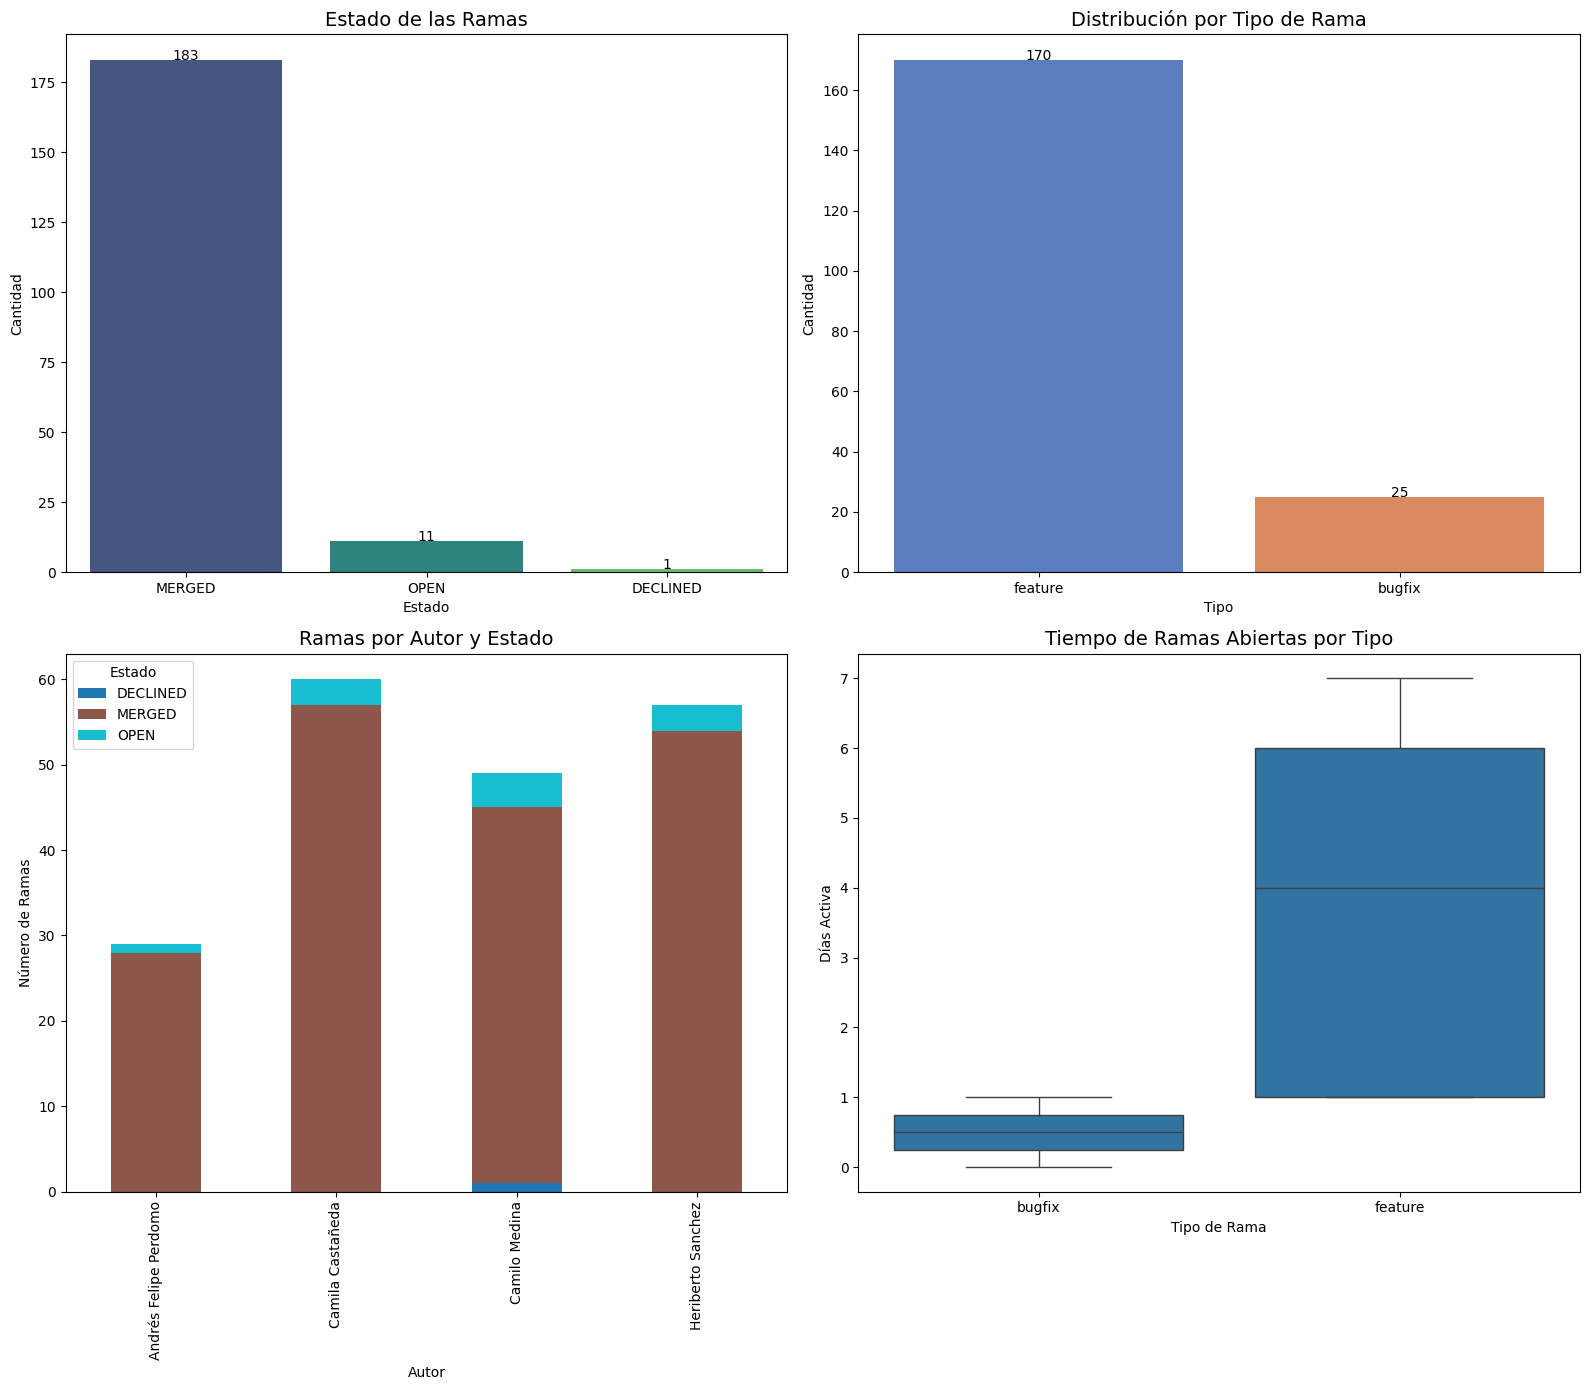

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_15008\633397198.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_branches["closed_day"] = closed_branches["closed_date"].dt.date


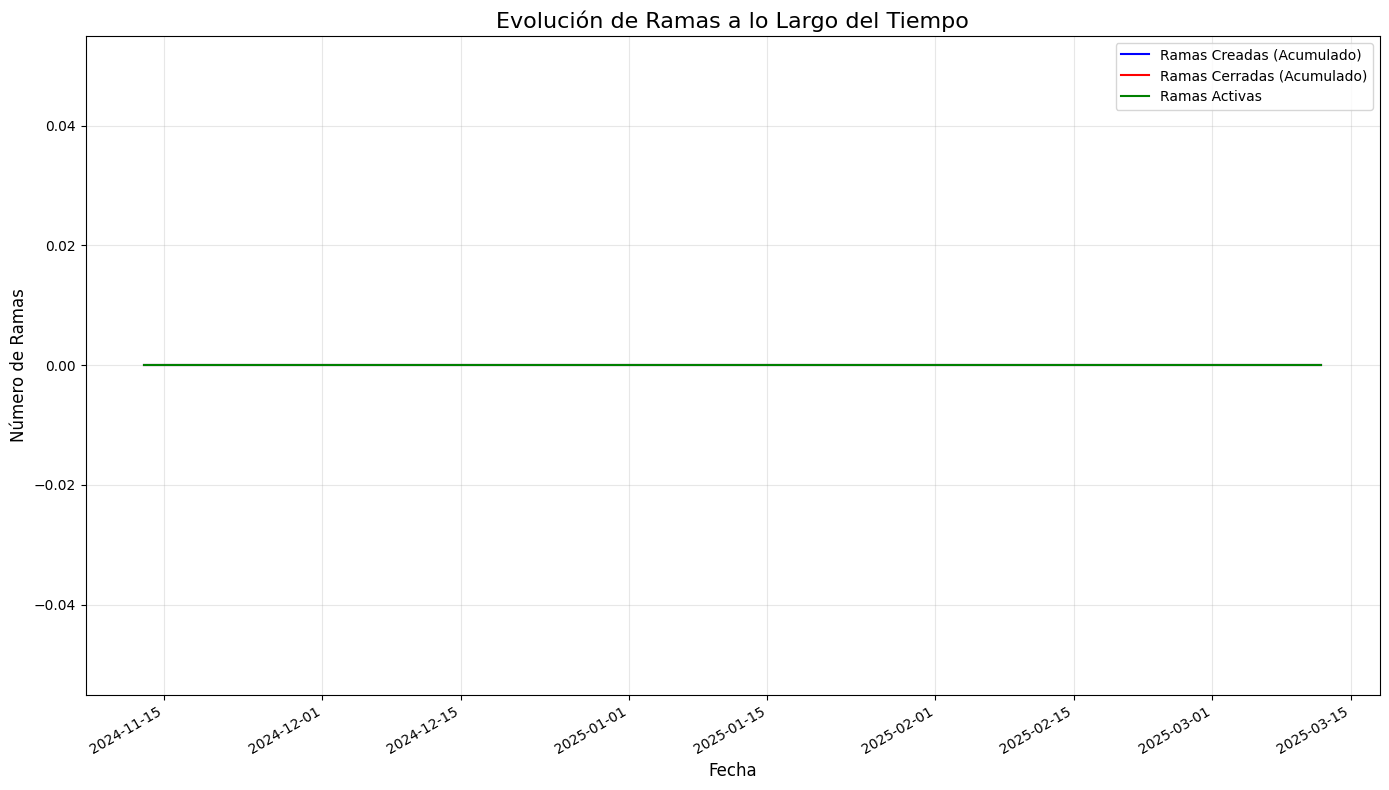


===== ANÁLISIS DE ACTIVIDAD EN RAMAS =====
Total de ramas analizadas: 195
Ramas por estado: {'MERGED': 183, 'OPEN': 11, 'DECLINED': 1}
Ramas por tipo: {'feature': 170, 'bugfix': 25}

Ramas abiertas por tiempo:
- bugfix: 2 ramas, promedio 0.5 días, máximo 1 días
- feature: 9 ramas, promedio 4.1 días, máximo 7 días

No hay ramas potencialmente abandonadas.

Patrones de creación de ramas por autor:
branch_type            bugfix  feature
author                                
Andrés Felipe Perdomo      10       19
Camila Castañeda            6       54
Camilo Medina               3       46
Heriberto Sanchez           6       51


In [231]:
import pandas as pd
import seaborn as sns
import numpy as np
# from datetime import datetime, timedelta

# Análisis de Actividad en Ramas
import matplotlib.pyplot as plt

# Extraer información de ramas de los PRs
branches_info = []

# Obtener información de las ramas desde los PR
for pr in df_pr.to_dict("records"):
    # Solo procesamos si tenemos información de rama
    if "branch" in pr and "type_branch" in pr:
        # Extraer tipo de rama (feature, bugfix, etc)
        branch_type = pr["type_branch"]
        # Nombre de la rama
        branch_name = pr["branch"]
        # Repositorio
        repo = pr["repository"]
        # Fecha de creación (estimada desde la PR)
        created_date = pr["created_on"]
        # Fecha de cierre (si está cerrada)
        closed_date = pr["updated_on"] if pr["state"] != "OPEN" else None
        # Estado actual
        state = pr["state"]
        # Autor de la rama (asumimos que es el mismo que el de la PR)
        author = pr["author"]

        # Agregar a la lista
        branches_info.append(
            {
                "branch_name": branch_name,
                "branch_type": branch_type,
                "repository": repo,
                "author": author,
                "created_date": created_date,
                "closed_date": closed_date,
                "state": state,
                "days_active": (pd.Timestamp.now(tz="UTC") - created_date).days
                if state == "OPEN"
                else (closed_date - created_date).days
                if closed_date
                else None,
            }
        )

# Crear DataFrame con la información de ramas
df_branches = pd.DataFrame(branches_info)

# 1. Análisis general de ramas
branch_states = df_branches["state"].value_counts().reset_index()
branch_states.columns = ["Estado", "Cantidad"]

# 2. Análisis por tipo de rama
branch_types = df_branches["branch_type"].value_counts().reset_index()
branch_types.columns = ["Tipo", "Cantidad"]

# 3. Ramas por autor
branches_by_author = df_branches.groupby(["author", "state"]).size().unstack().fillna(0)
if "OPEN" not in branches_by_author.columns:
    branches_by_author["OPEN"] = 0
if "MERGED" not in branches_by_author.columns:
    branches_by_author["MERGED"] = 0
if "DECLINED" not in branches_by_author.columns:
    branches_by_author["DECLINED"] = 0

# 4. Tiempo activo de las ramas
branch_lifetime = (
    df_branches.dropna(subset=["days_active"])
    .groupby(["branch_type", "state"])["days_active"]
    .agg(["mean", "median", "max"])
    .reset_index()
)

# 5. Ramas abiertas vs cerradas por repositorio
branches_by_repo = (
    df_branches.groupby(["repository", "state"]).size().unstack().fillna(0)
)

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Estado de las ramas
sns.barplot(
    x="Estado", y="Cantidad", data=branch_states, ax=axes[0, 0], palette="viridis"
)
axes[0, 0].set_title("Estado de las Ramas", fontsize=14)
for i, v in enumerate(branch_states["Cantidad"]):
    axes[0, 0].text(i, v + 0.1, str(v), ha="center")

# 2. Tipos de ramas
sns.barplot(x="Tipo", y="Cantidad", data=branch_types, ax=axes[0, 1], palette="muted")
axes[0, 1].set_title("Distribución por Tipo de Rama", fontsize=14)
for i, v in enumerate(branch_types["Cantidad"]):
    axes[0, 1].text(i, v + 0.1, str(v), ha="center")

# 3. Ramas por autor
branches_by_author.plot(kind="bar", stacked=True, ax=axes[1, 0], colormap="tab10")
axes[1, 0].set_title("Ramas por Autor y Estado", fontsize=14)
axes[1, 0].set_xlabel("Autor")
axes[1, 0].set_ylabel("Número de Ramas")
axes[1, 0].legend(title="Estado")

# 4. Tiempo promedio de las ramas abiertas
open_branches = df_branches[df_branches["state"] == "OPEN"]
if not open_branches.empty:
    sns.boxplot(x="branch_type", y="days_active", data=open_branches, ax=axes[1, 1])
    axes[1, 1].set_title("Tiempo de Ramas Abiertas por Tipo", fontsize=14)
    axes[1, 1].set_xlabel("Tipo de Rama")
    axes[1, 1].set_ylabel("Días Activa")

plt.tight_layout()
plt.show()

# 5. Gráfico adicional: Evolución de ramas a lo largo del tiempo
plt.figure(figsize=(14, 8))

# Crear fechas para el período analizado
start_date = df_branches["created_date"].min().date()
end_date = pd.Timestamp.now(tz="UTC").date()
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Contar ramas creadas por día
df_branches["created_day"] = df_branches["created_date"].dt.date
created_by_day = df_branches.groupby("created_day").size()

# Contar ramas cerradas por día
closed_branches = df_branches.dropna(subset=["closed_date"])
if not closed_branches.empty:
    closed_branches["closed_day"] = closed_branches["closed_date"].dt.date
    closed_by_day = closed_branches.groupby("closed_day").size()
else:
    closed_by_day = pd.Series(0, index=[])

# Preparar datos para el gráfico
created_cumsum = pd.Series(0, index=date_range)
closed_cumsum = pd.Series(0, index=date_range)

for day, count in created_by_day.items():
    if day in created_cumsum.index:
        created_cumsum[day] = count

for day, count in closed_by_day.items():
    if day in closed_cumsum.index:
        closed_cumsum[day] = count

# Calcular acumulados
created_cumsum = created_cumsum.cumsum()
closed_cumsum = closed_cumsum.cumsum()

# Calcular ramas activas (creadas - cerradas)
active_branches = created_cumsum - closed_cumsum

# Graficar
plt.plot(date_range, created_cumsum, "b-", label="Ramas Creadas (Acumulado)")
plt.plot(date_range, closed_cumsum, "r-", label="Ramas Cerradas (Acumulado)")
plt.plot(date_range, active_branches, "g-", label="Ramas Activas")

plt.title("Evolución de Ramas a lo Largo del Tiempo", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de Ramas", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Imprimir estadísticas
print("\n===== ANÁLISIS DE ACTIVIDAD EN RAMAS =====")
print(f"Total de ramas analizadas: {len(df_branches)}")
print(f"Ramas por estado: {dict(branch_states.values)}")
print(f"Ramas por tipo: {dict(branch_types.values)}")
print("\nRamas abiertas por tiempo:")
if not open_branches.empty:
    open_by_time = (
        open_branches.groupby("branch_type")["days_active"]
        .agg(["count", "mean", "median", "max"])
        .reset_index()
    )
    for _, row in open_by_time.iterrows():
        print(
            f"- {row['branch_type']}: {row['count']} ramas, promedio {row['mean']:.1f} días, máximo {row['max']} días"
        )

# Detectar ramas potencialmente abandonadas (abiertas por más de 30 días)
abandoned = open_branches[open_branches["days_active"] > 30].sort_values(
    "days_active", ascending=False
)
if not abandoned.empty:
    print("\nRamas potencialmente abandonadas (>30 días abiertas):")
    for _, row in abandoned.iterrows():
        print(
            f"- {row['branch_name']} ({row['repository']}): {row['days_active']} días, autor: {row['author']}"
        )
else:
    print("\nNo hay ramas potencialmente abandonadas.")

# Analizar patrones de creación de ramas por autor
author_patterns = (
    df_branches.groupby("author")["branch_type"].value_counts().unstack().fillna(0)
)
print("\nPatrones de creación de ramas por autor:")
print(author_patterns)

### Frecuencia de Merges

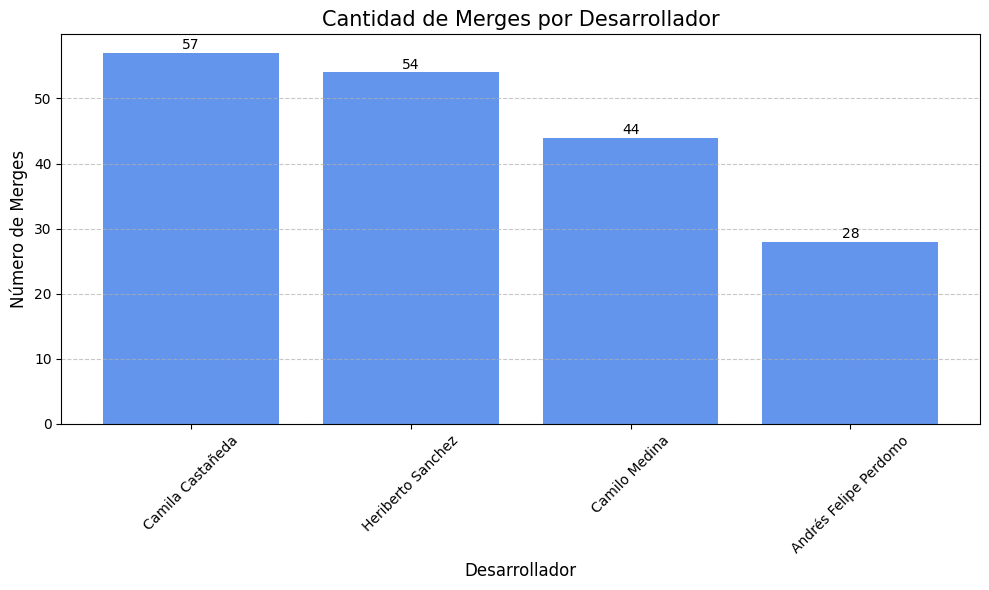

<Figure size 1200x600 with 0 Axes>

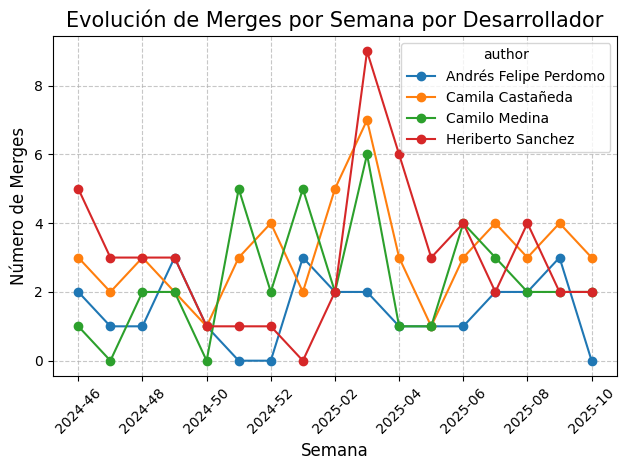

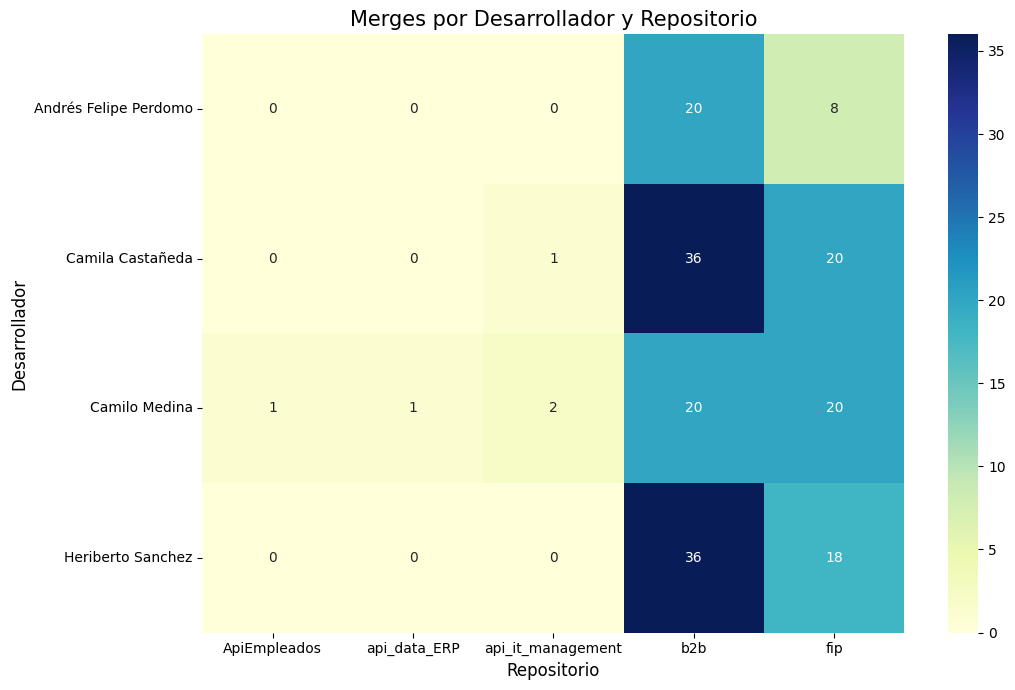


===== ANÁLISIS DE FRECUENCIA DE MERGES =====
Total de PRs mergeados: 183

Frequencia de merges por desarrollador:
- Camila Castañeda: 57 merges totales, 3.0 merges por semana
- Heriberto Sanchez: 54 merges totales, 3.2 merges por semana
- Camilo Medina: 44 merges totales, 2.6 merges por semana
- Andrés Felipe Perdomo: 28 merges totales, 1.8 merges por semana

Tiempo promedio entre merges consecutivos:
- Camila Castañeda: 2.1 días
- Heriberto Sanchez: 2.2 días
- Camilo Medina: 2.7 días
- Andrés Felipe Perdomo: 4.2 días


In [232]:
import pandas as pd
# import numpy as np
import seaborn as sns
# from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# Filtrar solo PRs que fueron mergeados
merged_prs = df_pr[df_pr["state"] == "MERGED"].copy()

# Convertir fechas a datetime si no lo están ya
merged_prs["merge_date"] = pd.to_datetime(merged_prs["updated_on"]).dt.date

# Análisis de merges por autor
merges_by_author = merged_prs.groupby("author").size().sort_values(ascending=False)
merges_by_author.name = "total_merges"

# Análisis temporal: merges por semana por autor
merged_prs["merge_week"] = pd.to_datetime(merged_prs["updated_on"]).dt.strftime("%Y-%U")
weekly_merges = (
    merged_prs.groupby(["author", "merge_week"]).size().reset_index(name="merges")
)
avg_weekly_merges = (
    weekly_merges.groupby("author")["merges"].mean().sort_values(ascending=False)
)
avg_weekly_merges.name = "avg_weekly_merges"

# Merges por repositorio
merges_by_repo_author = (
    merged_prs.groupby(["author", "repository"]).size().unstack(fill_value=0)
)

# Crear un DataFrame de resumen
merge_stats = pd.DataFrame(
    {"Total Merges": merges_by_author, "Promedio Semanal": avg_weekly_merges}
).reset_index()
merge_stats = merge_stats.sort_values("Total Merges", ascending=False)

# Visualización: Gráfico de barras para total de merges por autor
plt.figure(figsize=(10, 6))
bars = plt.bar(
    merge_stats["author"], merge_stats["Total Merges"], color="cornflowerblue"
)

# Agregar etiquetas de valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.1,
        f"{int(height)}",
        ha="center",
        va="bottom",
    )

plt.title("Cantidad de Merges por Desarrollador", fontsize=15)
plt.xlabel("Desarrollador", fontsize=12)
plt.ylabel("Número de Merges", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Visualización: Gráfico de líneas para evolución temporal de merges
plt.figure(figsize=(12, 6))

# Crear un DataFrame pivotado para visualizar merges por semana
weekly_pivot = weekly_merges.pivot(
    index="merge_week", columns="author", values="merges"
).fillna(0)

# Asegurar que tenemos todas las semanas en el rango
all_weeks = (
    pd.date_range(
        start=merged_prs["updated_on"].min().date(),
        end=merged_prs["updated_on"].max().date(),
        freq="W",
    )
    .strftime("%Y-%U")
    .tolist()
)
weekly_pivot = weekly_pivot.reindex(all_weeks, fill_value=0)

# Graficar la evolución temporal
weekly_pivot.plot(marker="o")
plt.title("Evolución de Merges por Semana por Desarrollador", fontsize=15)
plt.xlabel("Semana", fontsize=12)
plt.ylabel("Número de Merges", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualización: Gráfico de calor para merges por repositorio
plt.figure(figsize=(11, 7))
sns.heatmap(merges_by_repo_author, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Merges por Desarrollador y Repositorio", fontsize=15)
plt.ylabel("Desarrollador", fontsize=12)
plt.xlabel("Repositorio", fontsize=12)
plt.tight_layout()
plt.show()

# Estadísticas de frecuencia de merges
print("\n===== ANÁLISIS DE FRECUENCIA DE MERGES =====")
print(f"Total de PRs mergeados: {len(merged_prs)}")
print("\nFrequencia de merges por desarrollador:")
for _, row in merge_stats.iterrows():
    print(
        f"- {row['author']}: {int(row['Total Merges'])} merges totales, {row['Promedio Semanal']:.1f} merges por semana"
    )

# Calcular tiempo promedio entre merges por desarrollador
developer_merge_gaps = {}
for author in merged_prs["author"].unique():
    author_prs = merged_prs[merged_prs["author"] == author].sort_values("updated_on")
    if len(author_prs) > 1:
        gaps = []
        for i in range(1, len(author_prs)):
            gap = (
                author_prs.iloc[i]["updated_on"] - author_prs.iloc[i - 1]["updated_on"]
            ).total_seconds() / 86400  # días
            gaps.append(gap)
        developer_merge_gaps[author] = np.mean(gaps)

if developer_merge_gaps:
    print("\nTiempo promedio entre merges consecutivos:")
    for author, avg_days in sorted(developer_merge_gaps.items(), key=lambda x: x[1]):
        print(f"- {author}: {avg_days:.1f} días")